# Note

This notebook is full of computationally heavy tasks. Therefore to avoid recalculating all that I have always dumped heavily calculated objects in `dumped_objects` under the variable's name `<var_name>.pckl`. Try to load the objects instead of recalculating demanding processes.

# Data Loading

We load the initial training data. Skip this entire section if the train model is available under `analysis_best_model/best_model_bayesian_optimization.h5` and jump down to <font style="font-size:13pt; font-weight: bold">Load The Model<font>

## Calculating Fingerprints

In [1]:
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs

import numpy as np

import time

import pickle

from IPython.display import SVG

In [2]:
supplier = Chem.SDMolSupplier('data/cas_4337.sdf')
infos = [{} for mol in supplier]
# for every molecule, calculate all found fingerprints
fingerprints = np.array([AllChem.GetMorganFingerprintAsBitVect(supplier[i], 3, nBits=2048, bitInfo=infos[i]) 
                         for i in range(len(supplier))])

In [3]:
infos[0]

{47: ((6, 3),),
 119: ((3, 2),),
 155: ((0, 1),),
 305: ((13, 3),),
 322: ((22, 1),),
 323: ((1, 1),),
 371: ((20, 3),),
 378: ((5, 0),),
 389: ((16, 2), (19, 2)),
 434: ((5, 3),),
 471: ((4, 2),),
 498: ((11, 3), (14, 3)),
 507: ((0, 3),),
 566: ((3, 3),),
 661: ((2, 2),),
 695: ((23, 0),),
 718: ((20, 2), (21, 2)),
 736: ((6, 2), (9, 2), (7, 2), (10, 2)),
 781: ((23, 2),),
 798: ((0, 2),),
 831: ((22, 2),),
 840: ((1, 3),),
 841: ((24, 1),),
 859: ((2, 3),),
 896: ((17, 2), (18, 2)),
 1057: ((24, 0),),
 1088: ((11, 1), (14, 1), (12, 1), (16, 1), (15, 1), (19, 1)),
 1114: ((3, 0),),
 1160: ((2, 1), (4, 1), (13, 1)),
 1199: ((11, 2), (12, 2), (14, 2), (15, 2)),
 1218: ((5, 2),),
 1322: ((4, 3),),
 1380: ((0, 0), (1, 0), (2, 0), (4, 0), (8, 0), (13, 0), (22, 0)),
 1454: ((8, 2),),
 1472: ((1, 2),),
 1523: ((17, 3),),
 1536: ((23, 1),),
 1609: ((8, 1),),
 1698: ((13, 2),),
 1745: ((3, 1),),
 1750: ((6, 1), (7, 1), (9, 1), (10, 1), (17, 1), (18, 1), (20, 1), (21, 1)),
 1831: ((8, 3),),
 1

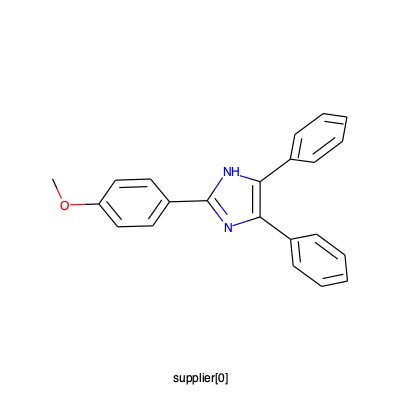

In [4]:
img = Draw.MolToImage(supplier[0], size=(400, 400), legend="supplier[0]", useSVG=True)
img.save('plots/supplier[0].png')
img

In [5]:
from wand.image import Image
def save_svg2png(filename='mona-lisa.png', resolution=1920, size=(800, 800)):
    """Reads an SVG string and converts it to png image. The png image is stored under the name 'mona-lisa.png' if
    no name has been provided. Function returns the png image object too for further desired processing.
    Params:
    --------
    filename:   path where the image should be stored
    size:       (tuple) specifies the dimension of the result image
    resolution: (int) specifies resolution of the result image. Default is 1920. That's almost HD.
    """
    svg_image = Image(blob=bytes(svg,'UTF-8'), format="svg", resolution=resolution) # increase resolution
    svg_image.resize(size[0], size[1]) 
    png_image = Image(blob=svg_image.make_blob("png"), format="png")
    png_image.save(filename=filename)
    return png_image

Here the bit (fingerprint) $736$ can be found 4 times in this molecule, let's have a look where.

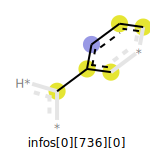

In [6]:
svg = Draw.DrawMorganBit(supplier[0], 736, infos[0], 0, legend='infos[0][736][0]')
save_svg2png('plots/infos[0][736][0].png')
SVG(svg)

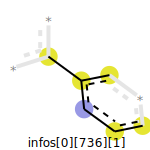

In [7]:
svg = Draw.DrawMorganBit(supplier[0], 736, infos[0], 1, legend='infos[0][736][1]')
save_svg2png('plots/infos[0][736][1].png')
SVG(svg)

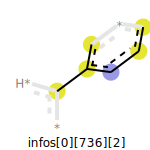

In [8]:
svg = Draw.DrawMorganBit(supplier[0], 736, infos[0], 2, legend='infos[0][736][2]')
save_svg2png('plots/infos[0][736][2].png')
SVG(svg)

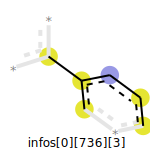

In [9]:
svg = Draw.DrawMorganBit(supplier[0], 736, infos[0], 3, legend='infos[0][736][3]')
save_svg2png('plots/infos[0][736][3].png')
SVG(svg)

## Splitting Dataset

into train and validation sets. These are the validation indices that we'll extract from the entire dataset.

In [10]:
valid_ids = [6,   10,   29,   32,   42,   58,   72,   83,   98,  100,  128, 
        145,  148,  168,  171,  205,  208,  237,  244,  285,  290,  291,
         300,  312,  332,  334,  335,  347,  356,  369,  371,  377,  407,
         424,  456,  458,  470,  472,  486,  514,  515,  528,  557,  563,
         599,  610,  616,  628,  640,  701,  704,  722,  764,  794,  818,
         821,  840,  850,  856,  859,  874,  878,  882,  898,  901,  925,
         936,  945,  957,  974,  977, 1013, 1019, 1030, 1038, 1047, 1049,
        1072, 1073, 1100, 1159, 1168, 1187, 1190, 1194, 1201, 1202, 1233,
        1247, 1258, 1264, 1273, 1283, 1288, 1300, 1302, 1319, 1339, 1349,
        1402, 1413, 1416, 1422, 1426, 1435, 1454, 1465, 1483, 1502, 1513,
        1515, 1520, 1548, 1576, 1604, 1606, 1621, 1650, 1695, 1696, 1711,
        1714, 1716, 1725, 1743, 1746, 1752, 1780, 1788, 1794, 1799, 1813,
        1826, 1866, 1886, 1901, 1903, 1921, 1929, 1940, 1969, 1970, 1997,
        1998, 2008, 2010, 2011, 2018, 2023, 2046, 2060, 2064, 2080, 2081,
        2131, 2171, 2182, 2203, 2212, 2224, 2231, 2241, 2246, 2283, 2294,
        2295, 2297, 2327, 2329, 2331, 2349, 2357, 2360, 2365, 2397, 2413,
        2417, 2418, 2421, 2448, 2467, 2510, 2516, 2528, 2533, 2549, 2562,
        2601, 2604, 2606, 2609, 2611, 2632, 2644, 2653, 2677, 2682, 2685,
        2692, 2703, 2708, 2714, 2719, 2726, 2732, 2759, 2761, 2776, 2780,
        2817, 2818, 2829, 2837, 2857, 2858, 2884, 2899, 2902, 2905, 2911,
        2939, 2975, 2977, 2986, 3007, 3009, 3018, 3024, 3038, 3066, 3087,
        3098, 3107, 3117, 3122, 3139, 3157, 3161, 3164, 3217, 3223, 3233,
        3263, 3265, 3271, 3290, 3295, 3307, 3313, 3317, 3321, 3382, 3384,
        3388, 3400, 3409, 3412, 3419, 3423, 3449, 3470, 3487, 3488, 3503,
        3509, 3511, 3539, 3562, 3626, 3637, 3654, 3662, 3663, 3668, 3671,
        3688, 3689, 3695, 3710, 3726, 3743, 3744, 3782, 3791, 3794, 3808,
        3809, 3841, 3849, 3874, 3910, 3912, 3925, 3945, 3950, 3958, 3959,
        3962, 3964, 3967, 3978, 3993, 4009, 4010, 4055, 4057, 4085, 4089,
        4096, 4099, 4107, 4112, 4129, 4135, 4151, 4155, 4196, 4209, 4216,
        4234, 4236, 4251, 4267, 4283, 4317, 4326, 4335
]

Every molecule whose index is found in `valid_ids`, add to the validation set, and every molecule that isn't is added to the training set.

In [11]:
X_train = []
X_valid = []
for i in range(len(fingerprints)):
    if i in valid_ids:
        X_valid.append(fingerprints[i])
    else:
        X_train.append(fingerprints[i])
X_train = np.array(X_train)
X_valid = np.array(X_valid)

Collecting the lables from the supplier

In [12]:
y_train, y_valid, i = [], [], 0
for mol in supplier:
    if mol.GetProp("Ames test categorisation") == "mutagen":
        if i in valid_ids:
            y_valid.append(1)
        else:
            y_train.append(1)
    else:
        if i in valid_ids:
            y_valid.append(0)
        else:
            y_train.append(0)
    i+=1
    
y_train = np.array(y_train)
y_valid = np.array(y_valid)

## Optimizing Model's Architecture

Using the Bayesian Inference. Here we use as a target metric the AUC score return by the model when run on the validation set. At the end we compare each to the one returned on the test set.

In [57]:
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam, RMSprop, Adagrad

from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization

Here we set the our search space as well as the substitution function

In [141]:
len(['lecun_uniform', 'he_uniform', 'uniform', 'he_normal', 'normal'])

5

In [143]:
param_reference = {'init': ['lecun_uniform', 'he_uniform', 'uniform', 'he_normal', 'normal'],
             'activation': ['relu', 'sigmoid', 'selu'],
              'optimizer': ['SGD', 'Adam', 'RMSprop']
                  }

search_space = {'units': (5, 1024), # discrete
                'activation': (0, 2), # categorical
                'optimizer': (0, 2), # categorical
                'lr': (.00001, .2), # continuous
                'n_layers': (2, 15), # discrete
                'epochs': (5, 30), # discrete
                'batch_size': (1, 200), # discrete
                'momentum': (0.001, 0.5), # continuous
                'init': (0, 4), # categorical
                'dropout_rate': (0.0001, 0.5) # continuous
               }



input_dim = X_valid.shape[1]
def train_evaluate_and_auc(units, activation, optimizer, lr, n_layers, epochs, batch_size, momentum, init, dropout_rate):
    # handle categorical
    activation = param_reference['activation'][int(round(activation))]
    optimizer = param_reference['optimizer'][int(round(optimizer))]
    init = param_reference['init'][int(round(init))]
    # handle discrete
    units = int(round(units))
    n_layers = int(round(n_layers))
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    tac()
    
    # build classifier with corresponding hyperparameters
    k.clear_session()
    classifier = Sequential()
    classifier.add(
        Dense(units=units, input_dim=input_dim, activation=activation, kernel_initializer=init) # input layer
    )
    # Create an arbitrary number of Hidden Layers
    for n in range(n_layers):
        classifier.add(Dense(units=units, activation=activation))
        classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units=1, activation='sigmoid'))     # Output Layer
    optimizer_eval = eval(optimizer+'(learning_rate={}, momentum={})'.format(lr, momentum)) if optimizer=='SGD' else eval(optimizer+'(learning_rate={})'.format(lr))
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer_eval, metrics=['accuracy'])
    classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    return roc_auc_score(y_valid, classifier.predict(X_valid))

The following cell provides just an implementation for accurate timing for the elapsed time in calculating the integrated gradients.

In [53]:
import time

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

run and time the Bayesian optimization process. Or better run this on the cluster. Therefore I'll dump the data that's need to run the optimization process.

In [67]:
with open('dumped_objects/bits.pckl', 'wb') as f:
    pickle.dump([X_train, X_valid, y_train, y_valid], f)

In [ ]:
with open('dumped_objects/bits.pckl', 'rb') as f:
    X_train, X_valid, y_train, y_valid = pickle.load(f)

This cell is very heavy, don't run unless deliberate

In [144]:
tic()
optimization = BayesianOptimization(f=train_evaluate_and_auc, pbounds=search_space, random_state=0, verbose=0)
optimization.maximize(init_points=20, n_iter=40)
print("Bayesian Optimization took")
tac()
optimization.max

Time passed: 0hour:0min:0sec
Time passed: 0hour:0min:38sec
Time passed: 0hour:3min:42sec
Time passed: 0hour:4min:31sec
Time passed: 0hour:5min:20sec
Time passed: 0hour:5min:26sec
Time passed: 0hour:5min:33sec
Time passed: 0hour:5min:37sec
Time passed: 0hour:5min:45sec
Time passed: 0hour:6min:45sec
Time passed: 0hour:6min:47sec
Time passed: 0hour:9min:22sec
Time passed: 0hour:9min:54sec
Time passed: 0hour:10min:11sec
Time passed: 0hour:10min:34sec
Time passed: 0hour:15min:33sec
Time passed: 0hour:15min:40sec
Time passed: 0hour:15min:55sec
Time passed: 0hour:16min:4sec
Time passed: 0hour:16min:17sec
Time passed: 0hour:17min:3sec
Time passed: 0hour:19min:10sec
Time passed: 0hour:22min:51sec
Time passed: 0hour:33min:46sec
Time passed: 0hour:53min:16sec
Time passed: 0hour:53min:30sec
Time passed: 0hour:53min:46sec
Time passed: 0hour:54min:5sec
Time passed: 0hour:54min:21sec
Time passed: 1hour:0min:7sec
Time passed: 1hour:3min:59sec
Time passed: 1hour:4min:40sec
Time passed: 1hour:6min:52sec

{'target': 0.9048096571558314,
 'params': {'activation': 0.0,
  'batch_size': 138.64074771309762,
  'dropout_rate': 0.0001,
  'epochs': 30.0,
  'init': 4.0,
  'lr': 0.2,
  'momentum': 0.5,
  'n_layers': 2.0,
  'optimizer': 0.0,
  'units': 805.6230341965053}}

### Set of best hyperparameters

Because the optimization treats all hyperparameters in a continuous way, let's convert them into a interpretable way.

In [146]:
import re
def convert_to_interpretable_dict(optimization_max):
    """ Returns an interpretable dictionary given the a single dictionary from the Bayesian Optimization object above
    """
    interpretable_dict = {}
    interpretable_dict['AUC'] = optimization_max['target']
    interpretable_dict['activation'] = param_reference['activation'][int(round(optimization_max['params']['activation']))] # categorical
    interpretable_dict['batch_size'] = int(round(optimization_max['params']['batch_size']))
    interpretable_dict['dropout_rate'] = optimization_max['params']['dropout_rate']
    interpretable_dict['epochs'] = int(round(optimization_max['params']['epochs']))
    interpretable_dict['init'] = param_reference['init'][int(round(optimization_max['params']['init']))] # categorical
    interpretable_dict['lr'] = optimization_max['params']['lr']
    interpretable_dict['momentum'] = optimization_max['params']['momentum']
    interpretable_dict['n_layers'] = int(round(optimization_max['params']['n_layers']))
#     interpretable_dict['optimizer'] = re.findall("[A-Z|a-z]+\'", str(param_reference['optimizer'][int(round(optimization_max['params']['optimizer']))]))[0][:-1] # categorical
    interpretable_dict['optimizer'] = param_reference['optimizer'][int(round(optimization_max['params']['optimizer']))] # categorical
    interpretable_dict['units'] = int(round(optimization_max['params']['units']))
    return interpretable_dict

Here we list the history of the Bayesian optimization hyperparameters search listed by their AUC score.

In [147]:
import pandas as pd

interpretable_dicts = {}
for param, i in zip(optimization.res, range(len(optimization.res))):    
    interpretable_dicts[i+1] = convert_to_interpretable_dict(param)
param_summary = pd.DataFrame.from_dict(interpretable_dicts, orient='index')
param_summary.to_csv('analysis_best_model/param_summary.csv')
param_summary.sort_values('AUC', ascending=False).style.set_capztion("Results of Bayesian Optimization: best set of hyperparameters (Validation Set)").bar('AUC', color=color_map['pleasantgreen'])

## Running Models on Test set

Make sure to specify the `input_shape` instead of usual `input_dim`. <font style="font-family: georgia; font-weight: normal; font-size: 16pt">Keras</font> has updated there Dense constructor. Because there's a good chance for a model to have scored well on the validation set due to 'good' initialization, we want to avoid this optimistic selection criterion of the model and find out their AUCs on the test set each.

In [207]:
param_summary_dict = param_summary.sort_values('AUC', ascending=False).to_dict(orient='index')

aucs_test = {}
tic()
for (k, v), i in zip(param_summary_dict.items(), range(20)):
    # build model with corresponding hyperparameters
    K.clear_session()
    model = Sequential()
    model.add(
        Dense(units=v['units'], input_shape=X_valid[0].shape, activation=v['activation'], kernel_initializer=v['init']) # input layer
    )
    # Create an arbitrary number of Hidden Layers
    for n in range(v['n_layers']):
        model.add(Dense(units=v['units'], activation=v['activation']))
        model.add(Dropout(v['dropout_rate']))
    model.add(Dense(units=1, activation='sigmoid'))     # Output Layer
    optimizer_eval = eval(v['optimizer']+'(learning_rate={}, momentum={})'.format(v['lr'], v['momentum'])) if v['optimizer']=='SGD' else eval(v['optimizer']+'(learning_rate={})'.format(v['lr']))
    model.compile(loss='binary_crossentropy', optimizer=optimizer_eval, metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=v['batch_size'], epochs=v['epochs'], verbose=0)
    aucs_test[k] = roc_auc_score(y_test, model.predict(X_test))
    tac()

Time passed: 0hour:0min:33sec
Time passed: 0hour:0min:37sec
Time passed: 0hour:0min:42sec
Time passed: 0hour:1min:15sec
Time passed: 0hour:1min:45sec
Time passed: 0hour:2min:15sec
Time passed: 0hour:3min:33sec
Time passed: 0hour:3min:52sec
Time passed: 0hour:4min:24sec
Time passed: 0hour:4min:54sec
Time passed: 0hour:5min:1sec
Time passed: 0hour:5min:20sec
Time passed: 0hour:5min:26sec
Time passed: 0hour:37min:54sec
Time passed: 0hour:37min:59sec
Time passed: 0hour:38min:5sec
Time passed: 0hour:43min:37sec
Time passed: 0hour:43min:39sec
Time passed: 0hour:44min:33sec
Time passed: 0hour:48min:20sec


In [228]:
param_summary_test = param_summary.sort_values('AUC', ascending=False).iloc[:20]
param_summary_test['AUC'] = aucs_test.values()
param_summary_test.style.set_caption("First 20 best-scoring models from Bayesian Optimization: AUC score on Test set").bar('AUC', color=color_map['pleasantgreen'])

In [229]:
with open('dumped_objects/optimization.pckl', 'wb') as f:
    pickle.dump([optimization, param_summary, param_summary_test], f)

In [229]:
with open('dumped_objects/optimization.pckl', 'rb') as f:
    optimization, param_summary, param_summary_test = pickle.load(f)

Now we compare both aucs together and find out the one that scored highest on both. I.e. $MAX(AUC_{test} + AUC_{valid})$

In [239]:
auc_valid_test_comparison = pd.DataFrame.from_dict({'AUC_Valid': param_summary.sort_values('AUC', ascending=False).iloc[:20]['AUC'], 'AUC_Test': param_summary_test['AUC']})
auc_valid_test_comparison['Sum'] = auc_valid_test_comparison['AUC_Valid'] +  auc_valid_test_comparison['AUC_Test']
auc_valid_test_comparison.sort_values('Sum', ascending=False).style.set_caption("Comparison of AUC score of first 20 models (validation set vs. Test set").bar('Sum', color=color_map['pleasantgreen'])

### Loading Test set

Run the following 2 cells to load the test set, and then will obtain them in `X_test`, `y_test`

In [17]:
import csv

smiles, y_test = [], []
with open('data/test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        if row[1] != 'smiles':
            # read smiles from the 2nd column
            smiles.append(row[1])
            # read labels from the 3rd column
            y_test.append(row[2])

In [18]:
info_dicts, X_test, supplier_test = [], [], []
for smile in smiles:
    m = Chem.MolFromSmiles(smile)
    supplier_test.append(m)
    info = {}
    bit_vector = AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048, bitInfo=info)
    X_test.append(bit_vector)
    info_dicts.append(info)
    
X_test = np.array(X_test)
y_test = np.array(y_test, dtype=np.int8)

### Plotting test set ROC

In [164]:
def plot_roc(fpr, tpr, roc_auc, isTestset=True):
    plt.figure(figsize=(12, 10), dpi=200)
    lw = 2
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = ' + r'$\mathbf{%0.3f}$)'% roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=24)
    plt.ylabel('True Positive Rate', fontsize=24)
    title = 'Receiver operating characteristic'
    plt.title(title, fontsize=24)
    plt.legend(loc="lower right", fontsize=24)
    box_info = 'Test Set' if isTestset else 'Validation Set'
    plt.text(0.10, 0.95, box_info, fontsize=16, style='italic',
        verticalalignment='top', bbox=props)
    plt.savefig('plots/'+ title.replace(' ', '-') +'-'+ box_info.replace(' ', '-'))
    plt.show()

In [224]:
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_pred = model2.predict(X_test)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc(fpr, tpr, auc)

InvalidArgumentError: Tensor dense_1_input_1:0, specified in either feed_devices or fetch_devices was not found in the Graph

### Saving the model

For later uses. In order not to overwrite my original model, I generate a random number that gets appended to the end of the model's name.

In [162]:
import random
model.save("analysis_best_model/best_model_bayesian_optimization_{}.h5".format(random.randint(1,9999)))

### Load the Model

For later uses

In [166]:
from keras.models import load_model
model = load_model('analysis_best_model/best_model_bayesian_optimization.h5')

To see model evaluation, look at the cells above.
This was just a sanity check that I'd like to make, to make sure not to load the wrong model. So in order to check that this model has the same weights as the one reported in my last report, I had to load it and then reevaluate it on the test set, and see if I get the same AUC score.

In [128]:
from tensorflow import keras as keras_tf
keras_tf.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

# Integrated Gradients

In the following we provide an implementation for the integrated gradients. Steps of the implementation are:
1. Consider a baseline such that the output $F(x^\prime)=\bigcirc$ where $x^\prime$ is the baseline and $\bigcirc$ is the default class. In our case, we uses the zero-vector that actually signals the absence of any fingerprints.
2. Now, interpolate a series of images, increasing in intensity ($\alpha$), between the baseline image and the original (target) image. In another word, define a function $\gamma(\alpha) \rightarrow [0, 1]$ such that $F(x_i)=1$ and $F(x_i^\prime)=0$. In our implementation, this is defined as a *lambda* function in python.
3. Gradients of the output with respect to these series of interpolated images, when calculated gives us the following

$$grad = \left[ \begin{array}{rrrrrr}
[& 0.0073032 & g_2^1 & ... & g_m^1 &] \\
[& g_1^2 & g_2^2 & \cdots & g_m^2 &] \\
[& \vdots & \vdots & \cdots & \vdots  \\
[& g_1^s & g_2^s & \cdots & g_m^s &] \\
\end{array}\right.
\left. \begin{array}{rr}
\text{when} & \alpha=\frac{1}{s} \\
 & \alpha=\frac{2}{s} \\
 & \vdots \\
 & \alpha=1 \\
\end{array}\right] \
$$

> *FIXME: write out the rest of the steps*

4. Our region of interest lies where the slope of the score vs intensity graph doesn't remain stagnant. We call these gradients - *interesting gradients*. I.e. we calculate the gradient for every potentially possible input that lies between the original input $x_i$ and the baseline $x_i^\prime$. See `t_gradients` in the implementation.

5. The integration of these series of gradients give us the Integrated gradients of the image. The result of this step is a vector that has the same dimension as the input. And each element (attribution) in this vector corresponds to one features in the input sample. That's of course is equivalent to taking the average of the interesting gradients.

6. We repeat these steps for every sample in our dataset

### Author Implementation

In the following cell, I provide the implementation of the integrated gradients that the author provides (<u>not working</u>).

In [21]:
import tensorflow as tf
from keras import backend as keras
import numpy as np

def integrated_gradients(inp, baseline, label, steps=50):
    t_input = input_tensor() # input tensor
    t_prediction = prediciton_tensor(label) # output tensor
    t_gradients = tf.gradients(t_prediction, t_input)[0] # gradients
    path_inputs = [baseline + (i/steps)*(inp-baseline) for i in range(steps)]
    grads = run_network(t_gradients, path_inputs)
    return (inp-baseline)*np.average(grads, axis=0) # integration

### My Implementation (<font style="font-family: chalkboard">Working</font>)

In the following, I provide my own implementation of the integrated gradients according to my understanding of the math formula in the paper.

However, one downside of my implementation that it takes a bit more time on my 
<font style="font-family: times; font-size:11pt">3.1 GHz Dual-Core Intel Core i5</font> CPU ($\approx 16\, sec$ per one sample in the dataset). Therefore, for practicality use the GitHub implementation.

In [22]:
from keras import backend as k
import numpy as np
import time

def integrated_gradients(inp, baseline=None, steps=50):
    """My own implementation of the integrated gradients. I've made this over the formula under section "Computing
    Integrated Gradients". Returns the a vector of attributions where each element in the vector corresponds to one
    value in the input. The attributions vector has the same shape as the input.
    @Params
    ------
    inp:    The target input. i.e. One input sample (numpy.array) (e.g. one image, one molecule).
    baseline:      (Optional) The baseline vector - if not provided, the zero-vector is calcualted.
    steps:         (Optional), number of steps for integral estimation. = 50 by default

    @Returns
    -------
    Attribution vector
    """
    tic() # start timing the calculation
    gradients = []
    inp = inp.reshape(1, -1) # original input
    if baseline is None:
        baseline = np.zeros(inp.shape)
    # gamma calculates the path function for a given alpha
    gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)

    for alpha in range(steps+1):
        input_tensor = gamma(alpha).reshape(1, -1) # path input tensor
        output_tensor = model.predict(input_tensor) # output tensor
        gradient = k.gradients(model.output, model.input)[0]
        # run the session
        sess = k.get_session()
        results = sess.run(gradient, feed_dict={model.output: output_tensor, model.input: input_tensor})[0]
        gradients.append(results)

    gradients = np.array(gradients)
    tac() # print elapsed time
    return (inp-baseline) * np.average(gradients, axis=0)

To prove the correctness of the method try

$$F(x)-F(x^\prime)=\sum_{i=1}^m a_i$$

Where $a_i$ the $i^{th}$ attribution in the attributions vector $a = [a_1, a_2, ..., a_m]$

In [130]:
import pickle 
with open('dumped_objects/bits_test.pckl', 'wb') as f:
    pickle.dump([X_test, y_test], f)

In [23]:
attribution = integrated_gradients(X_test[0])
np.sum(attribution)

Time passed: 0hour:0min:7sec


-0.007345786834775936

In [24]:
baseline = np.zeros(shape=X_test[0].shape)
model.predict(X_test[0].reshape(1, -1)) - model.predict(baseline.reshape(1, -1))

array([[-0.00698315]], dtype=float32)

That's close enough, and therefore, we can make sure that the implementation is working accordingly, however, because my implementation takes a long time - namely $26\, sec$ for one input, so that's $$3315\times 26 = 86\, 190\, sec\approx 23.94\, h$$, I'll use the one from GitHub.

Prove that gamma is working $\gamma(x):R^d \rightarrow [0, 1]$  such that

$$\begin{align}
\gamma(x_i) = 1 &\qquad \text{when} &  x_i &=x \\
\gamma(x_i) = 0 &\qquad \text{when} & x_i &= baseline \\
\end{align}$$

In [25]:
gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)
inp = X_test[478]
baseline = np.zeros(shape=inp.shape)
steps = 50

print("Is gamma equal to input when alpha=1?")
print(gamma(1) == inp)
print("Is gamma equal to baseline when alpha=0?")
print(gamma(0) == baseline)
print("Is gamma equal to baseline when alpha=1?")
print(gamma(1) == baseline)
print("Is gamma equal to input when alpha=0?")
print(gamma(0) == input)

Is gamma equal to input when alpha=1?
[ True  True  True ...  True  True False]
Is gamma equal to baseline when alpha=0?
[ True  True  True ...  True  True  True]
Is gamma equal to baseline when alpha=1?
[ True  True  True ...  True  True False]
Is gamma equal to input when alpha=0?
[False False False ... False False False]


<br><br><br><br><br>

## Using GitHub Implemention

Because my implementation takes too long, I'm using this implementation from Github.

In [27]:
from modules.IntegratedGradients import integrated_gradients as IG
ig = IG(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


/Users/kareem/miniconda3/envs/chemoinformatics/lib/python3.7/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


### Default (Zero) baseline

The default baseline is a baseline where all entries correspond to the "default" class, such that the model predicts the negative class when the baseline is given as an input. 

In my case, that's a zero-vector, because that represents the absence of any fingerprints.

In [28]:
baseline = np.zeros(shape=X_test[0].shape)

We'll try different steps to calculate the baseline in order to overcome the numerical error.

In [29]:
attributions = {}
for step in range(50, 101, 10):
    attributions[step] = np.array([ig.explain(inp, reference=baseline, num_steps=step) for inp in X_test])

In [30]:
numerical_errors = {}
numerical_errors_avg = {}
for step in attributions.keys():
    diffs = (model.predict(X_test) - model.predict(baseline.reshape(1, -1))).reshape(-1,)
    sums = np.sum(attributions[step], axis=1)
    numerical_errors[step] = np.abs(np.abs(diffs) - np.abs(sums))
    numerical_errors_avg[step] = np.average(numerical_errors[step])

In [31]:
from matplotlib import pyplot as plt
import pandas as pd
color_map = {'verylightgreen': '#b3ffdb', 'verylightred': '#ffb3b3', 'verylightblue': '#a1c7c1', 'pleasantgreen': '#60a670', 'lightorange': '#ebc14d', 'darkorange': '#ad861a'}
color_palette = ["#911111", "#346b29", "#4257f5", "#748046", "#9da39d", "#124543"]

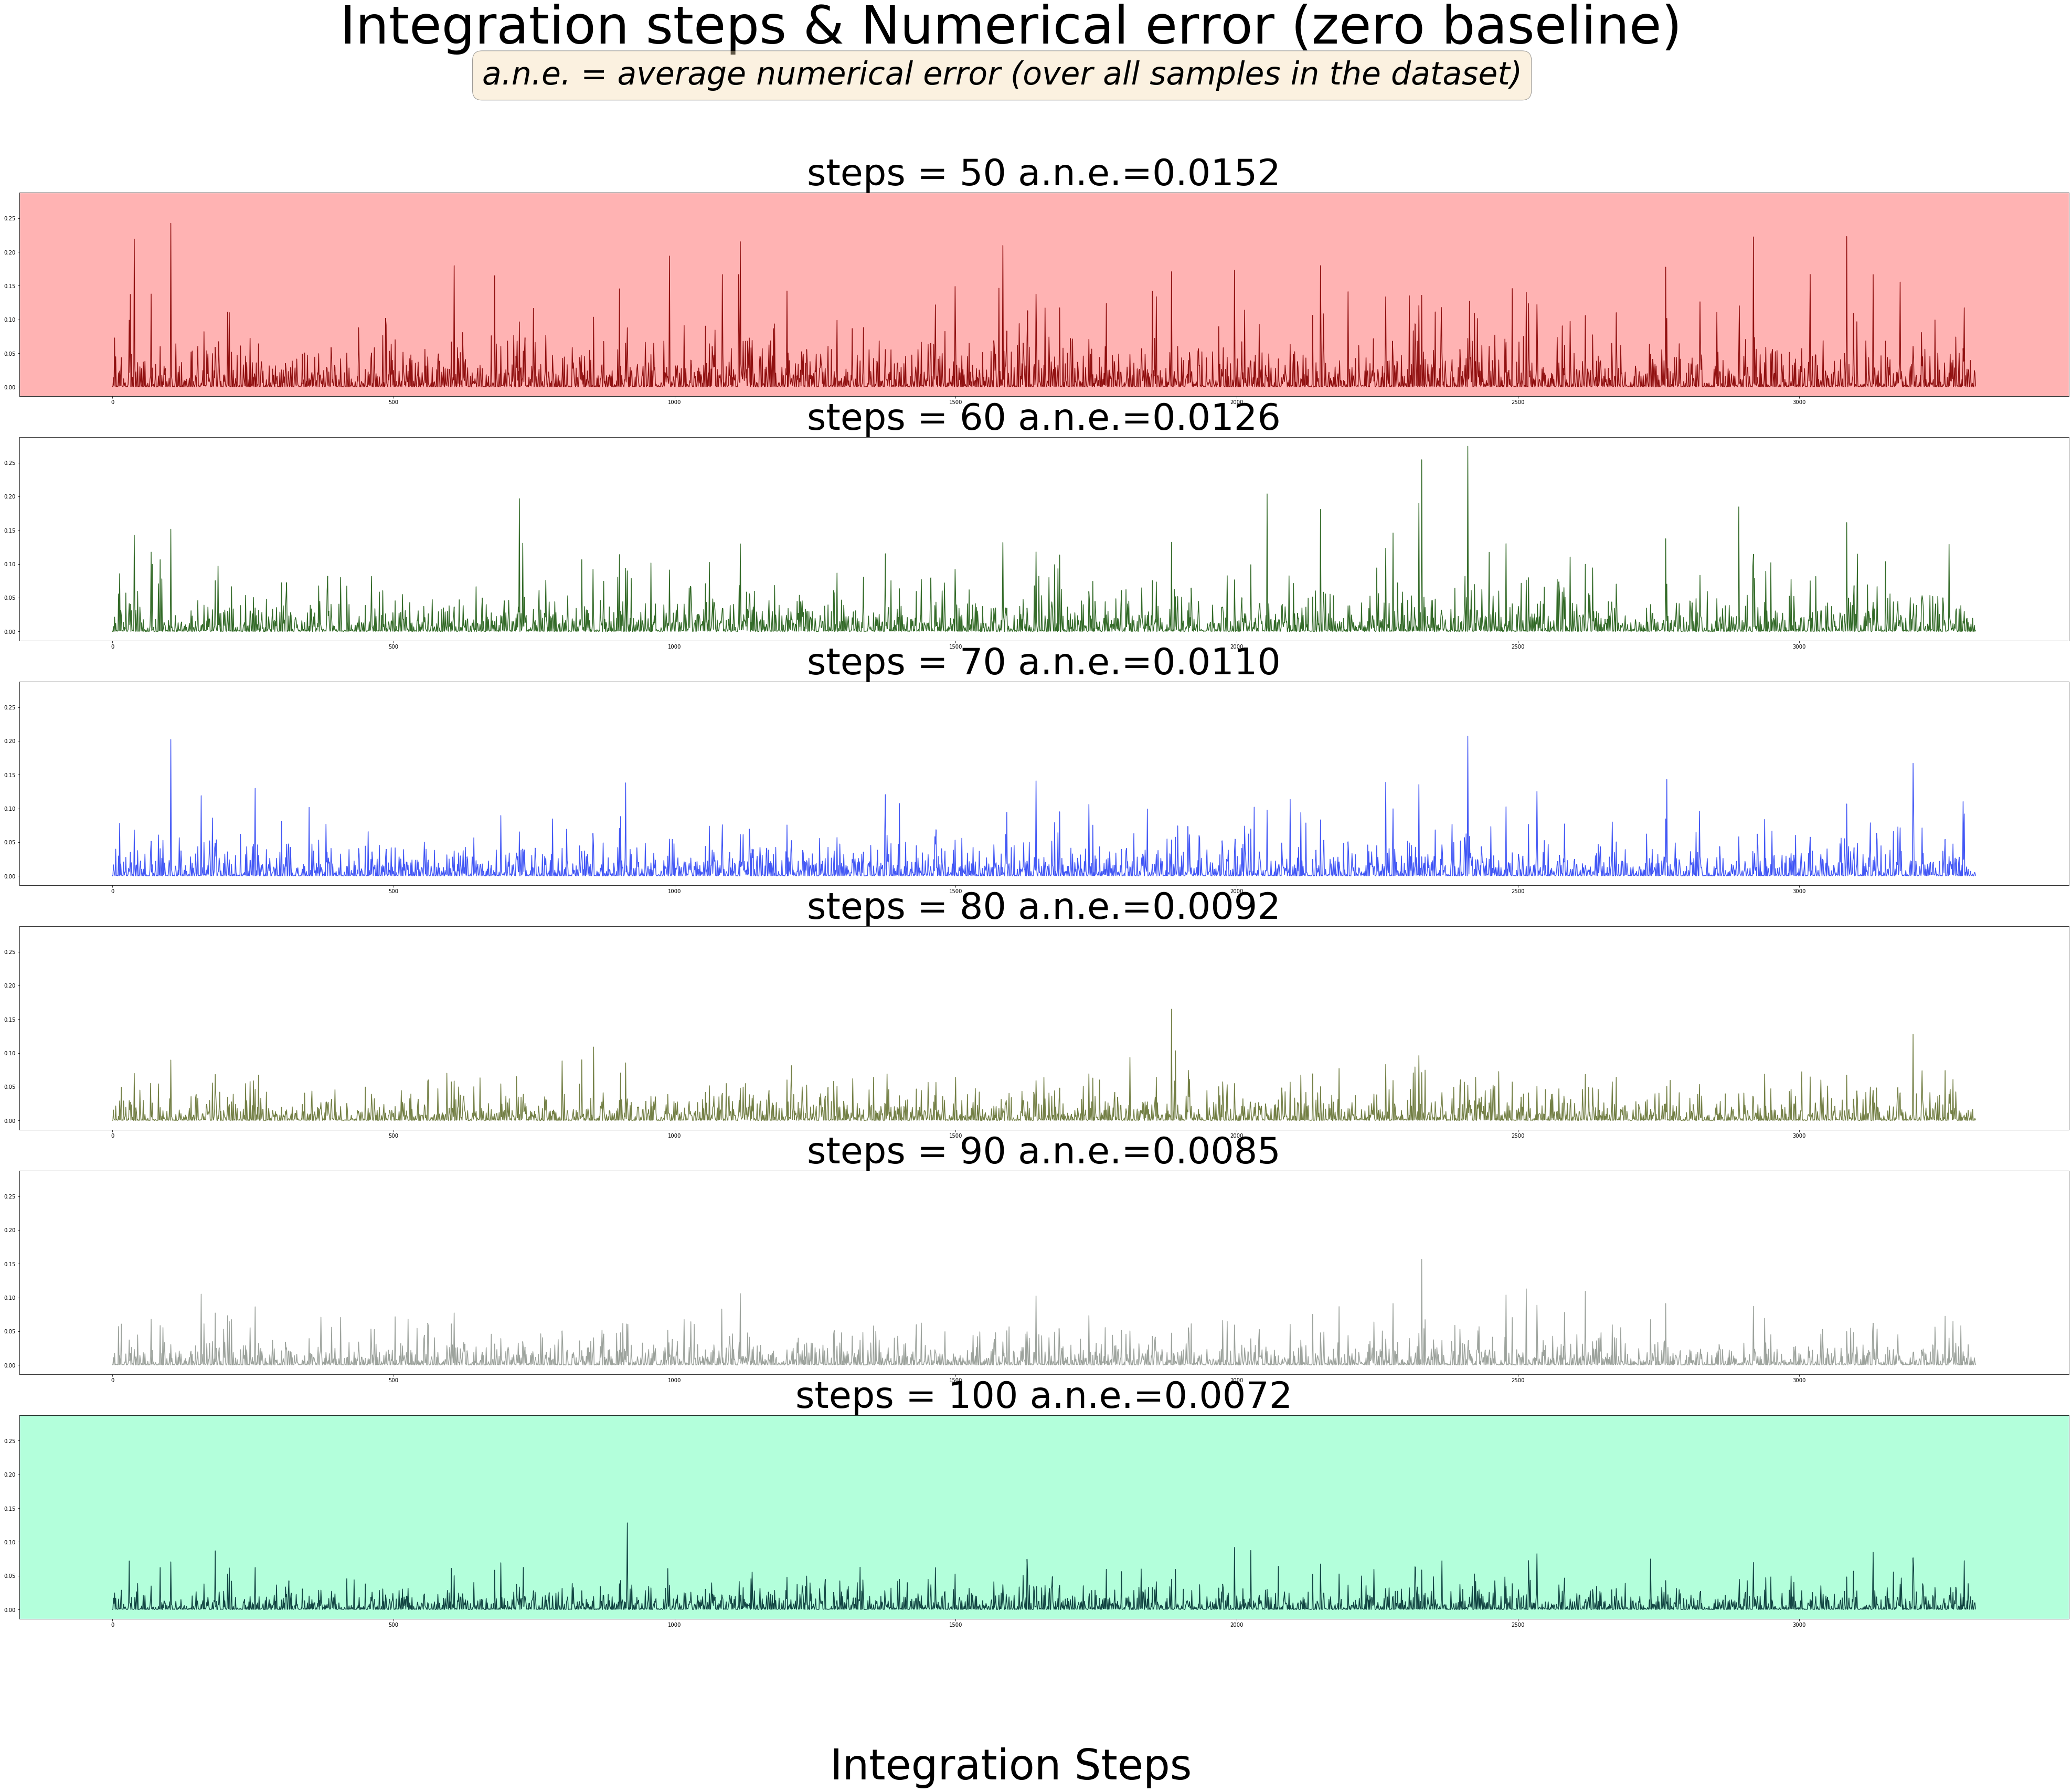

In [32]:
fig, axs = plt.subplots(6, 1, figsize=(70, 50), sharey=True)
for (k, v), i in zip(numerical_errors.items(), range(len(axs))):
    axs[i].plot(v, c=color_palette[i])
    axs[i].set_title("steps = {} a.n.e.={:.4f}".format(k, numerical_errors_avg[k]), fontsize=70)
axs[0].set_facecolor(color_map['verylightred'])
axs[5].set_facecolor(color_map['verylightgreen'])
title = "Integration steps & Numerical error (zero baseline)"
fig.suptitle(title, fontsize=100)
fig.text(0.5, 0.04, 'Integration Steps', ha='center', fontsize=80)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
fig.text(0.30, 0.95, 'a.n.e. = average numerical error (over all samples in the dataset)', fontsize=60, style='italic',
        verticalalignment='top', bbox=props)
fig.savefig('plots/{}'.format(title))
plt.show()

In [33]:
caption = "Average Numerical Errors (zero baseline)"
pd.DataFrame.from_dict(numerical_errors_avg, orient='index', columns=['Numerical Errors']).T.style.set_caption(caption).highlight_min(axis=1, color=color_map['verylightgreen']).highlight_max(axis=1, color=color_map['verylightred'])

### Modal baseline

A modal baseline is a baseline where each entry in the baseline corresponds to the most frequent value in a column in the attributions matrix.

We want to understand the importance of choosing a baseline when using the integrated gradients. In that regard, we'll try out a new gradient where the most occuring fingerprints are. 

In [34]:
from scipy.stats import mode
## get baseline of the most frequent fingerprint along rows
baseline_modal = mode(X_test, axis=0)[0].reshape(baseline.shape)

In [35]:
attributions_modal = {}
for step in range(50, 101, 10):    
    attributions_modal[step] = np.array([ig.explain(inp, reference=baseline_modal, num_steps=step) for inp in X_test])

In [36]:
modal_numerical_errors = {}
modal_numerical_errors_avg = {}
for step in attributions_modal.keys():
    diffs = (model.predict(X_test) - model.predict(baseline_modal.reshape(1, -1))).reshape(-1,)
    sums = np.sum(attributions_modal[step], axis=1)
    modal_numerical_errors[step] = np.abs(np.abs(diffs) - np.abs(sums))
    modal_numerical_errors_avg[step] = np.average(modal_numerical_errors[step])

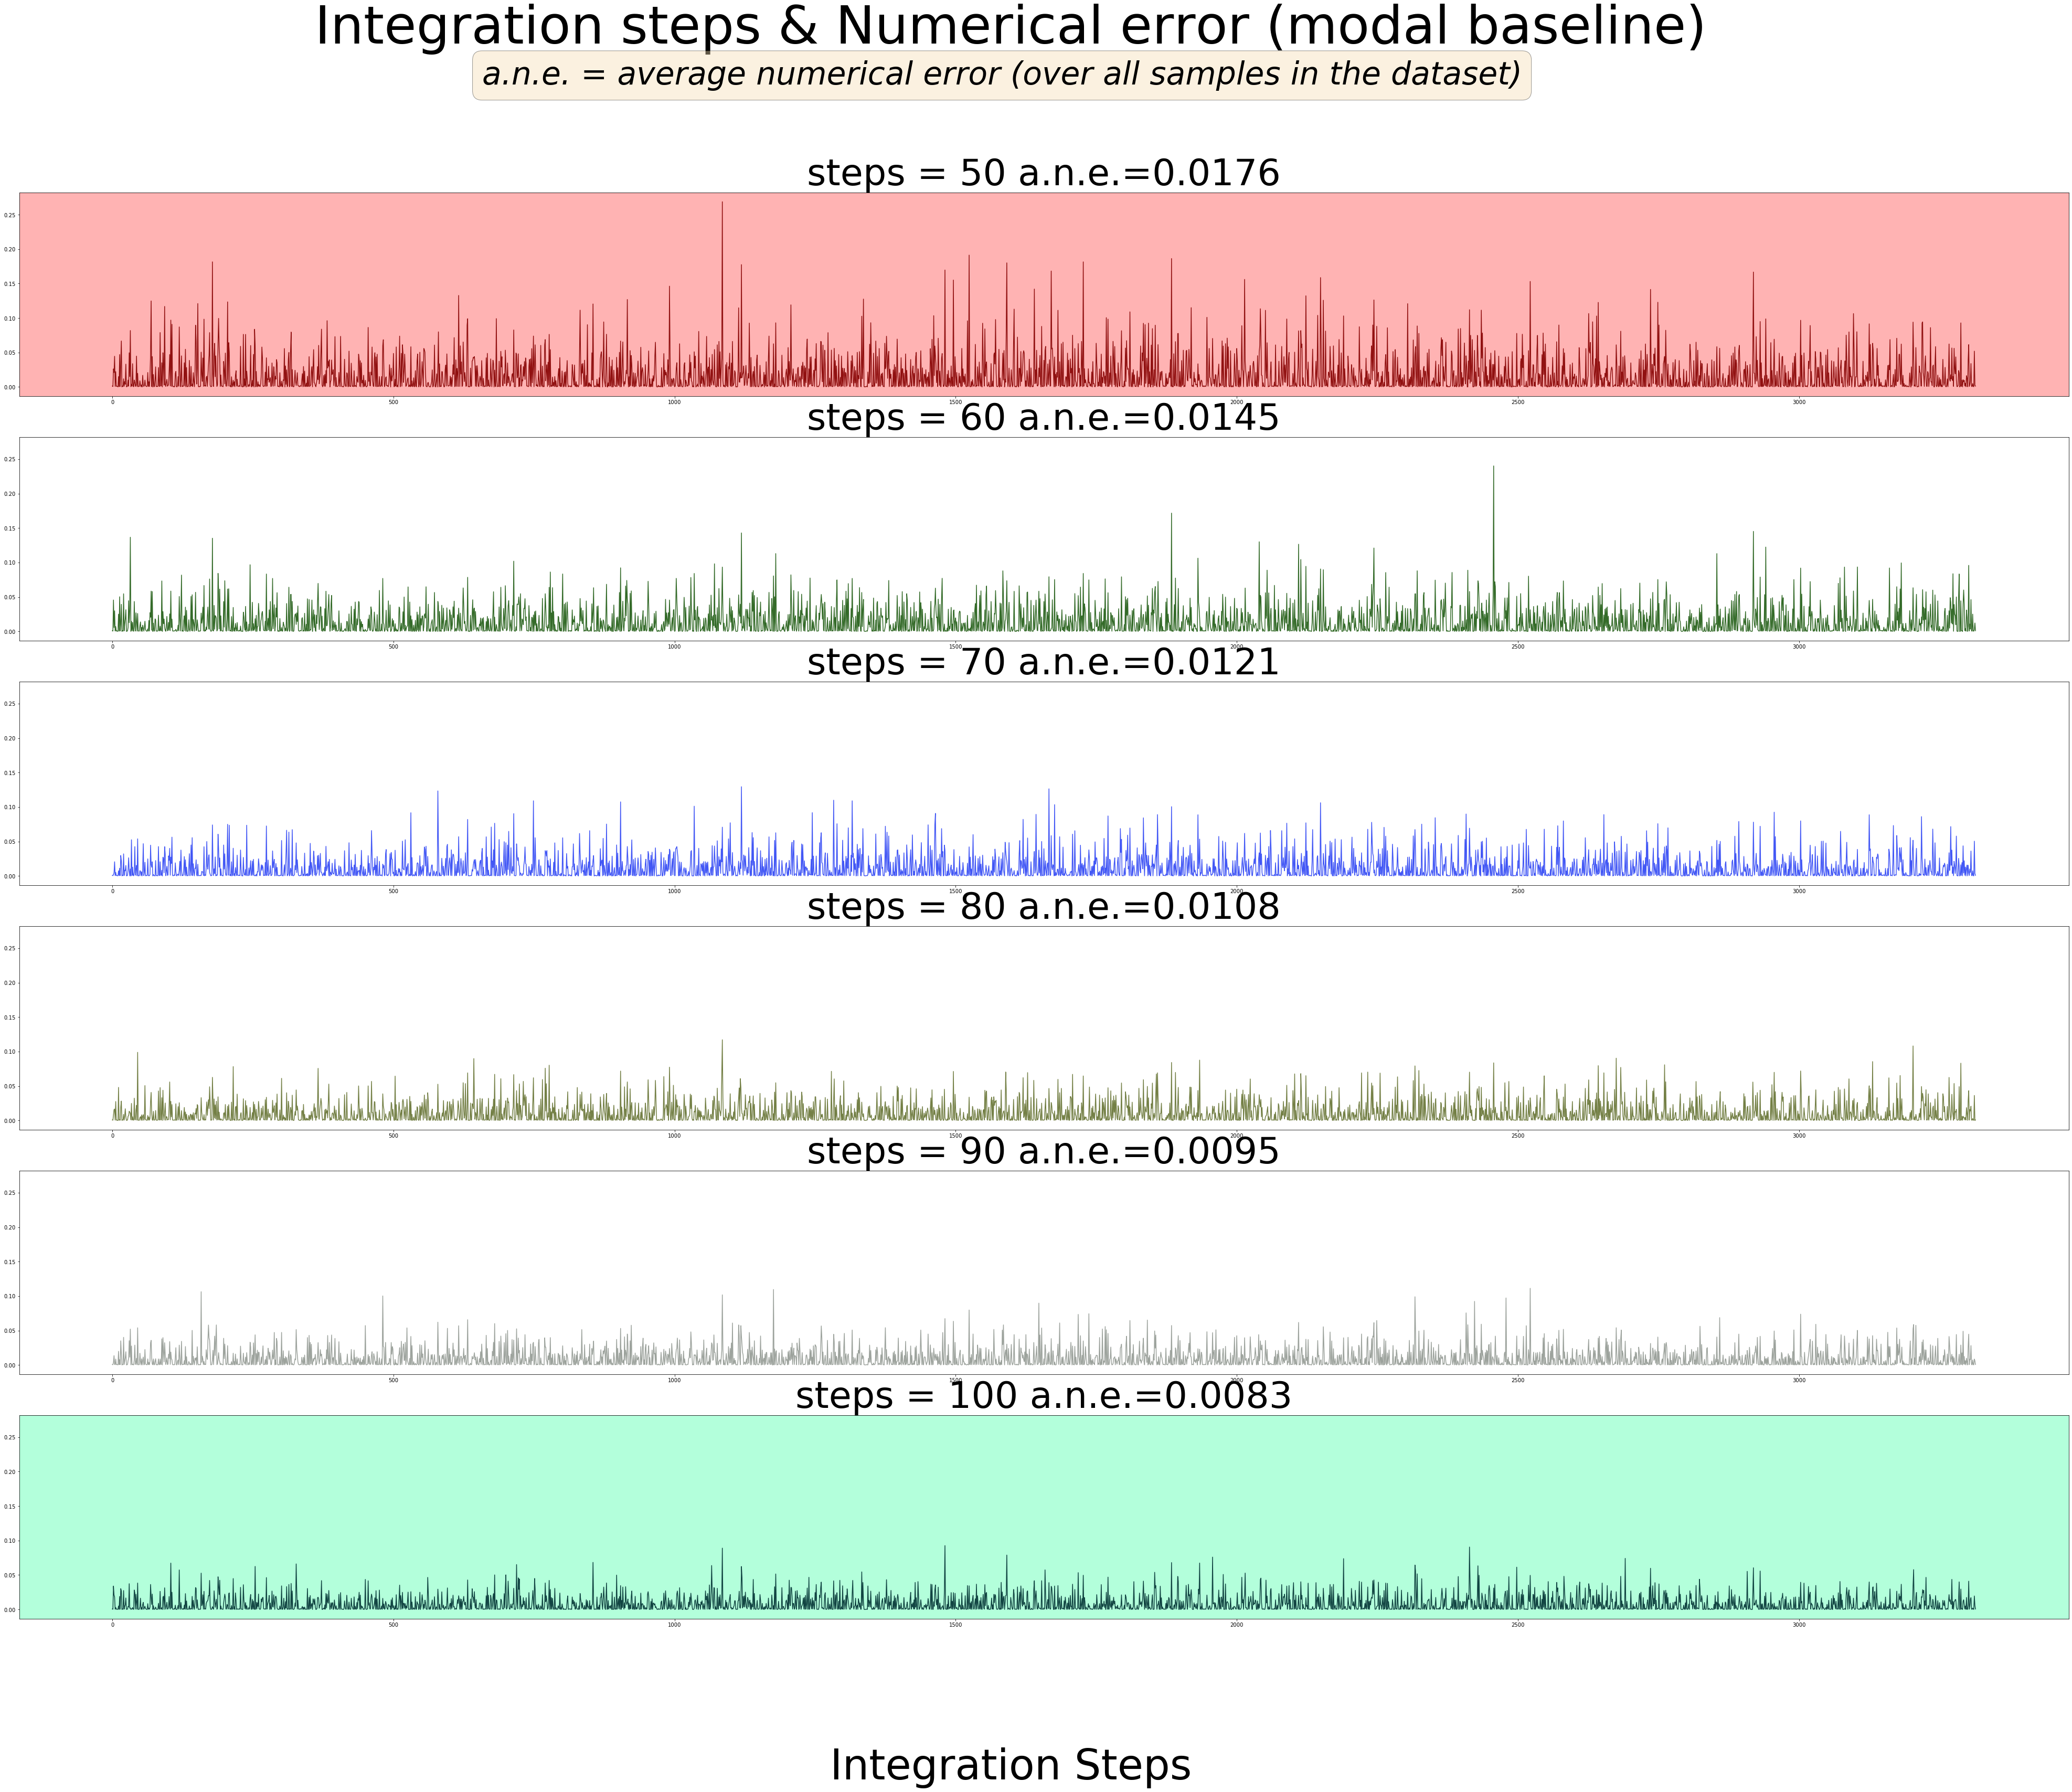

In [37]:
color_palette = ["#911111", "#346b29", "#4257f5", "#748046", "#9da39d", "#124543"]
fig, axs = plt.subplots(6, 1, figsize=(70, 50), sharey=True)
for (k, v), i in zip(modal_numerical_errors.items(), range(len(axs))):
    axs[i].plot(v, c=color_palette[i])
    axs[i].set_title("steps = {} a.n.e.={:.4f}".format(k, modal_numerical_errors_avg[k]), fontsize=70)
axs[0].set_facecolor(color_map['verylightred'])
axs[5].set_facecolor(color_map['verylightgreen'])
title = "Integration steps & Numerical error (modal baseline)"
fig.suptitle(title, fontsize=100)
fig.text(0.5, 0.04, 'Integration Steps', ha='center', fontsize=80)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
fig.text(0.30, 0.95, 'a.n.e. = average numerical error (over all samples in the dataset)', fontsize=60, style='italic',
        verticalalignment='top', bbox=props)
fig.savefig('plots/{}'.format(title))
plt.show()

In [38]:
caption = "Average Numerical Errors (modal baseline)"
pd.DataFrame.from_dict(modal_numerical_errors_avg, orient='index', columns=['Numerical Errors']).T.style.set_caption(caption).highlight_min(axis=1, color=color_map['verylightgreen']).highlight_max(axis=1, color=color_map['verylightred'])

### Average Baseline

I'll try the average baseline but I don't think it makes a lot of sense for our datasets, because now we'll get float values in the vector which isn't possible for a bit vector.

In [39]:
baseline_average = np.average(X_test, axis=0)

In [40]:
attributions_average = {}
for step in range(50, 101, 10):
    attributions_average[step] = np.array([ig.explain(inp, reference=baseline_average, num_steps=step) for inp in X_test])

In [41]:
average_numerical_errors = {}
average_numerical_errors_avg = {}
for step in attributions_average.keys():
    diffs = (model.predict(X_test) - model.predict(baseline_average.reshape(1, -1))).reshape(-1,)
    sums = np.sum(attributions_average[step], axis=1)
    average_numerical_errors[step] = np.abs(np.abs(diffs) - np.abs(sums))
    average_numerical_errors_avg[step] = np.average(average_numerical_errors[step])

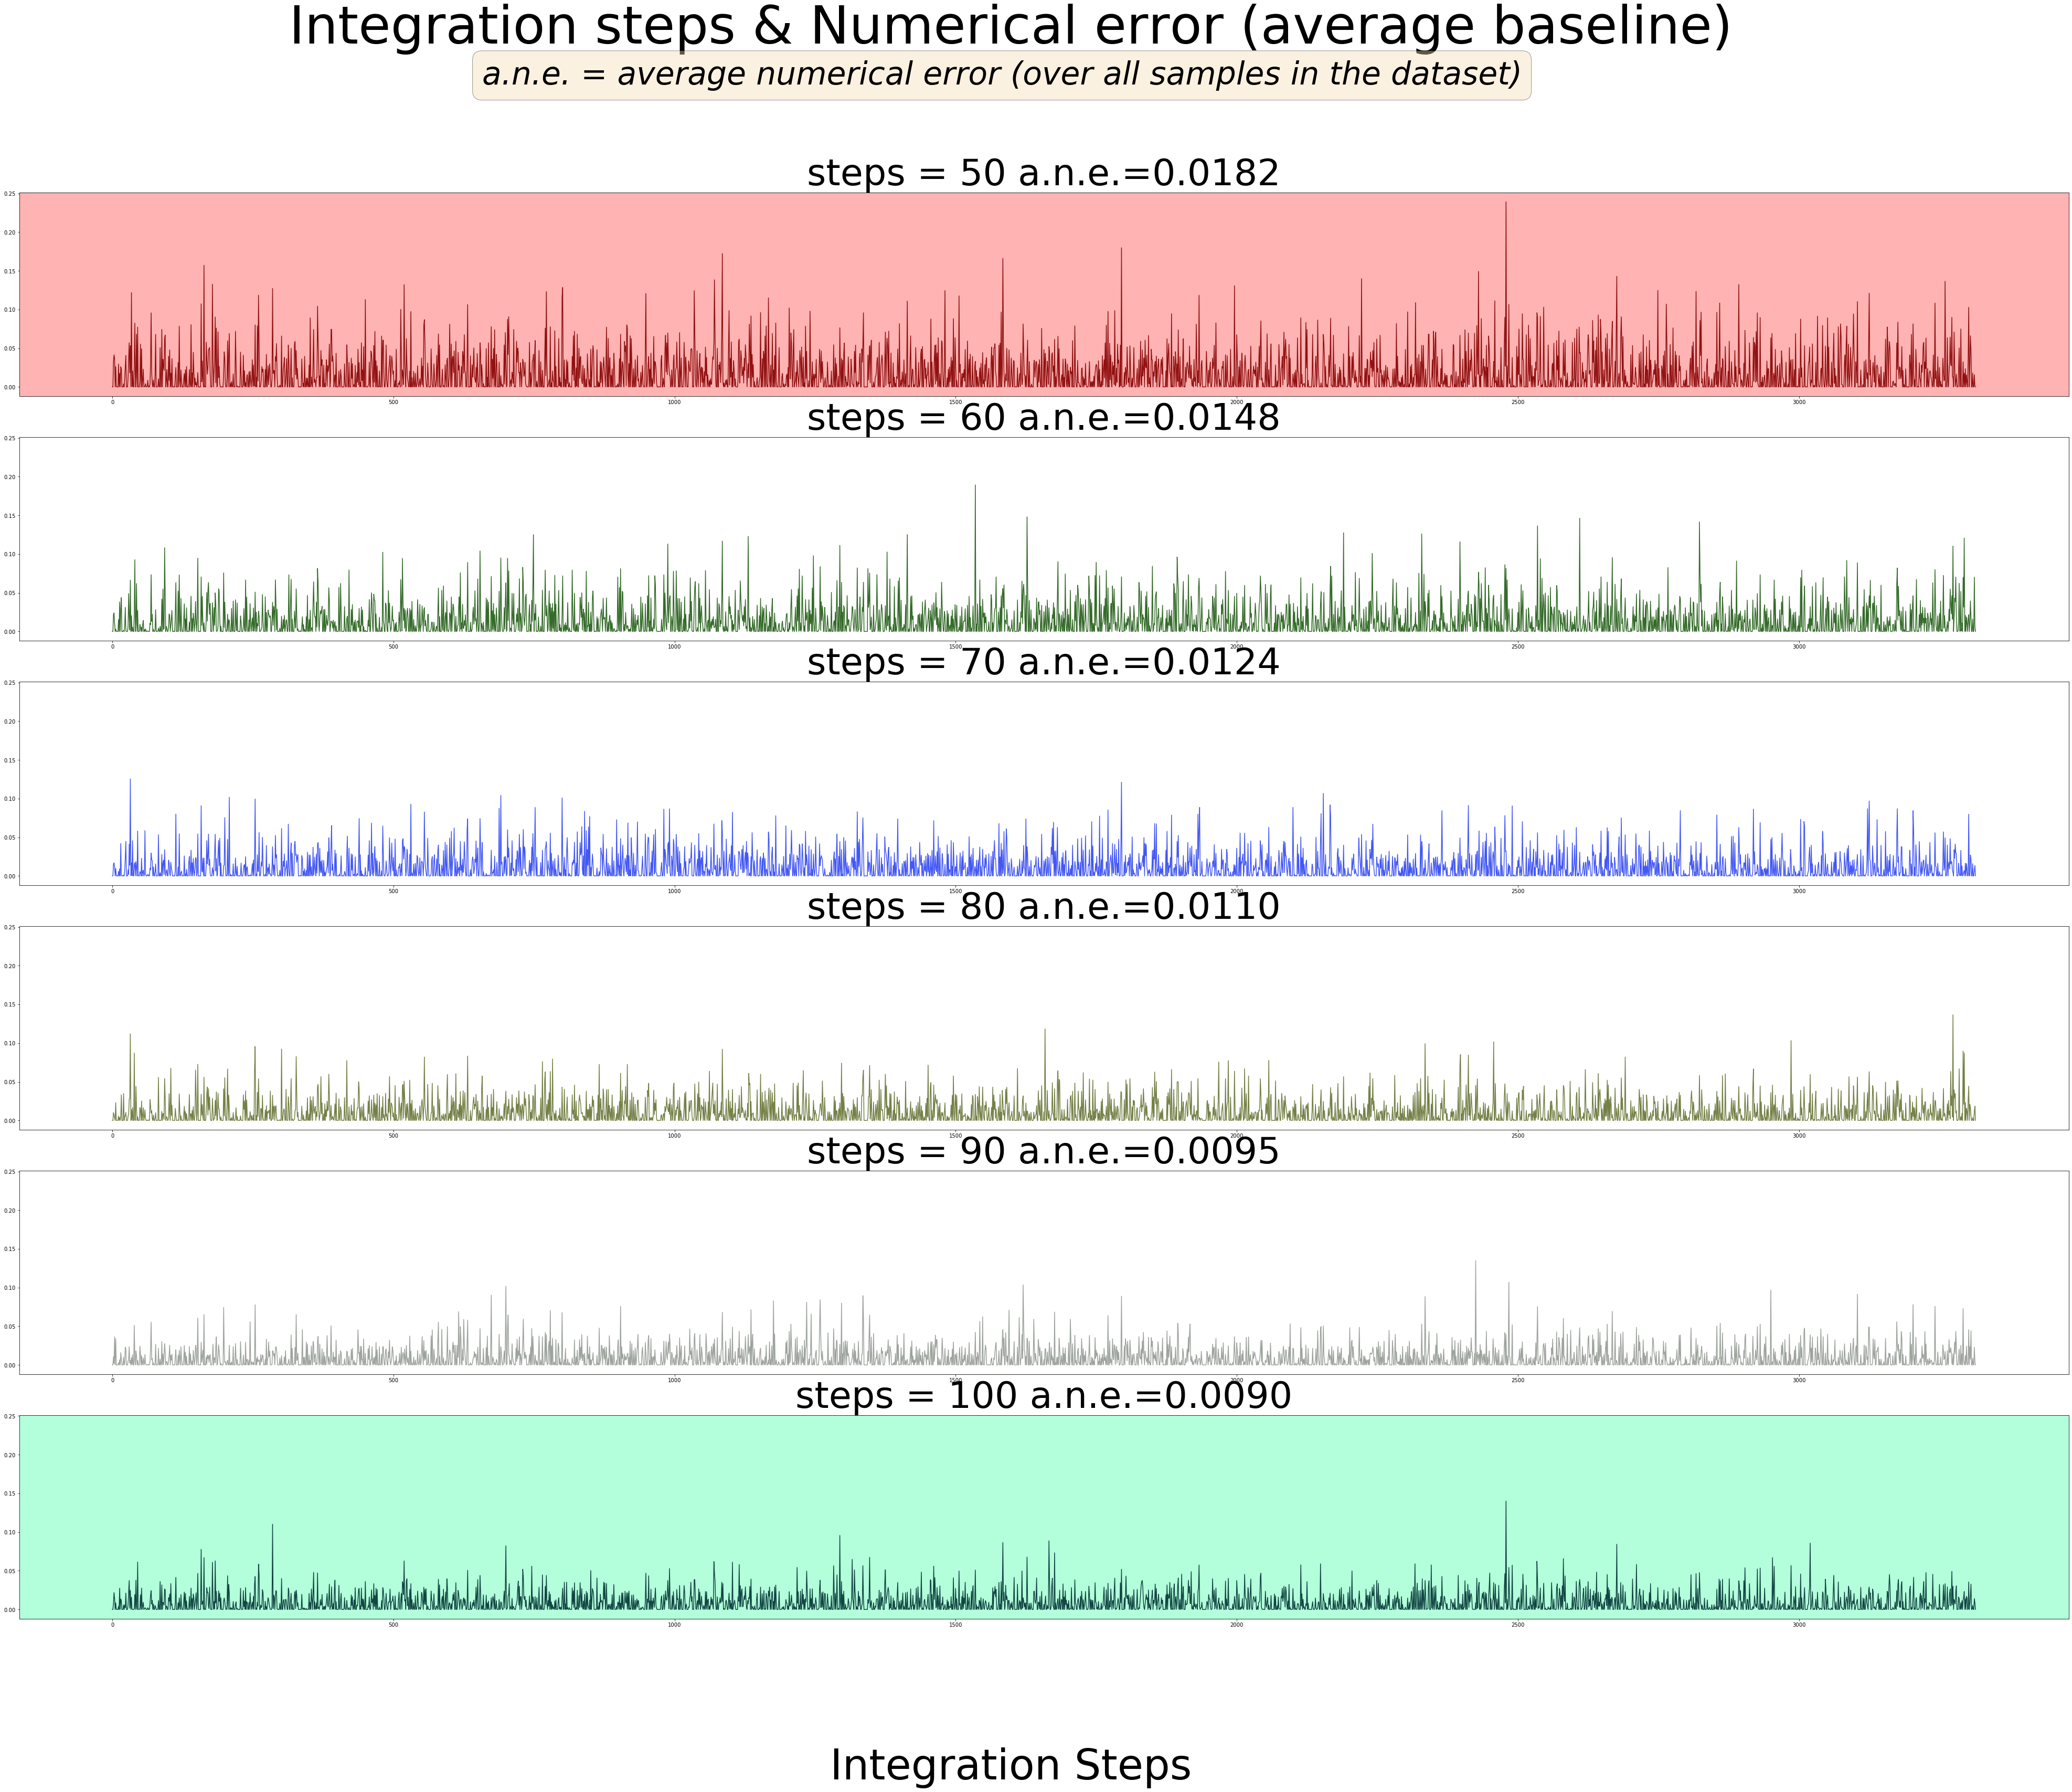

In [42]:
color_palette = ["#911111", "#346b29", "#4257f5", "#748046", "#9da39d", "#124543"]
fig, axs = plt.subplots(6, 1, figsize=(70, 50), sharey=True)
for (k, v), i in zip(average_numerical_errors.items(), range(len(axs))):
    axs[i].plot(v, c=color_palette[i])
    axs[i].set_title("steps = {} a.n.e.={:.4f}".format(k, average_numerical_errors_avg[k]), fontsize=70)
axs[0].set_facecolor(color_map['verylightred'])
axs[5].set_facecolor(color_map['verylightgreen'])
title = "Integration steps & Numerical error (average baseline)"
fig.suptitle(title, fontsize=100)
fig.text(0.5, 0.04, 'Integration Steps', ha='center', fontsize=80)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
fig.text(0.30, 0.95, 'a.n.e. = average numerical error (over all samples in the dataset)', fontsize=60, style='italic',
        verticalalignment='top', bbox=props)
fig.savefig('plots/{}'.format(title))
plt.show()

In [43]:
caption = "Average Numerical Errors (average baseline)"
pd.DataFrame.from_dict(average_numerical_errors_avg, orient='index', columns=['Numerical Errors']).T.style.set_caption(caption).highlight_min(axis=1, color=color_map['verylightgreen']).highlight_max(axis=1, color=color_map['verylightred'])

### Random Baseline

A random baseline is that one where each element is a random bit (either $1$ or $0$). However, here attention is to be paid to the fact that randomness introduces \*luck\*. Which means that in order to avoid randomly well-generated baseline, we have to generate the baseline a number of times and then average the result.

The following calculation is gonna take $45$ per cycle. That's $45 \times 50 =2250\, sec = 37.5\, min$ - *again on my CPU*.

In [51]:
## takes around 30 min
attributions_randoms = []
baselines_randoms = []
tic()
for i in range(50):
    attributions_random = {}
    baseline_random = np.random.randint(0, high=2, size=X_test.shape[1])
    baselines_randoms.append(baseline_random)
    for step in range(50, 101, 10):
        attributions_random[step] = np.array([ig.explain(inp, reference=baseline_random, num_steps=step) for inp in X_test])
    attributions_randoms.append(attributions_random)
    tac()
tac()

KeyboardInterrupt: 

This extra step is needed for the random baseline, because once we've calculated the errors for each baseline, we have to average the errors over the baselines (per one step).

In [687]:
numerical_errors_randoms = {}
numerical_errors_randoms_avg = {}
for step in range(50, 101, 10):
    numerical_errors_randoms[step] = np.average([abs_diff[step] for abs_diff in numerical_errors_randoms_per_step], axis=0)
    numerical_errors_randoms_avg[step] = np.average(numerical_errors_randoms[step])

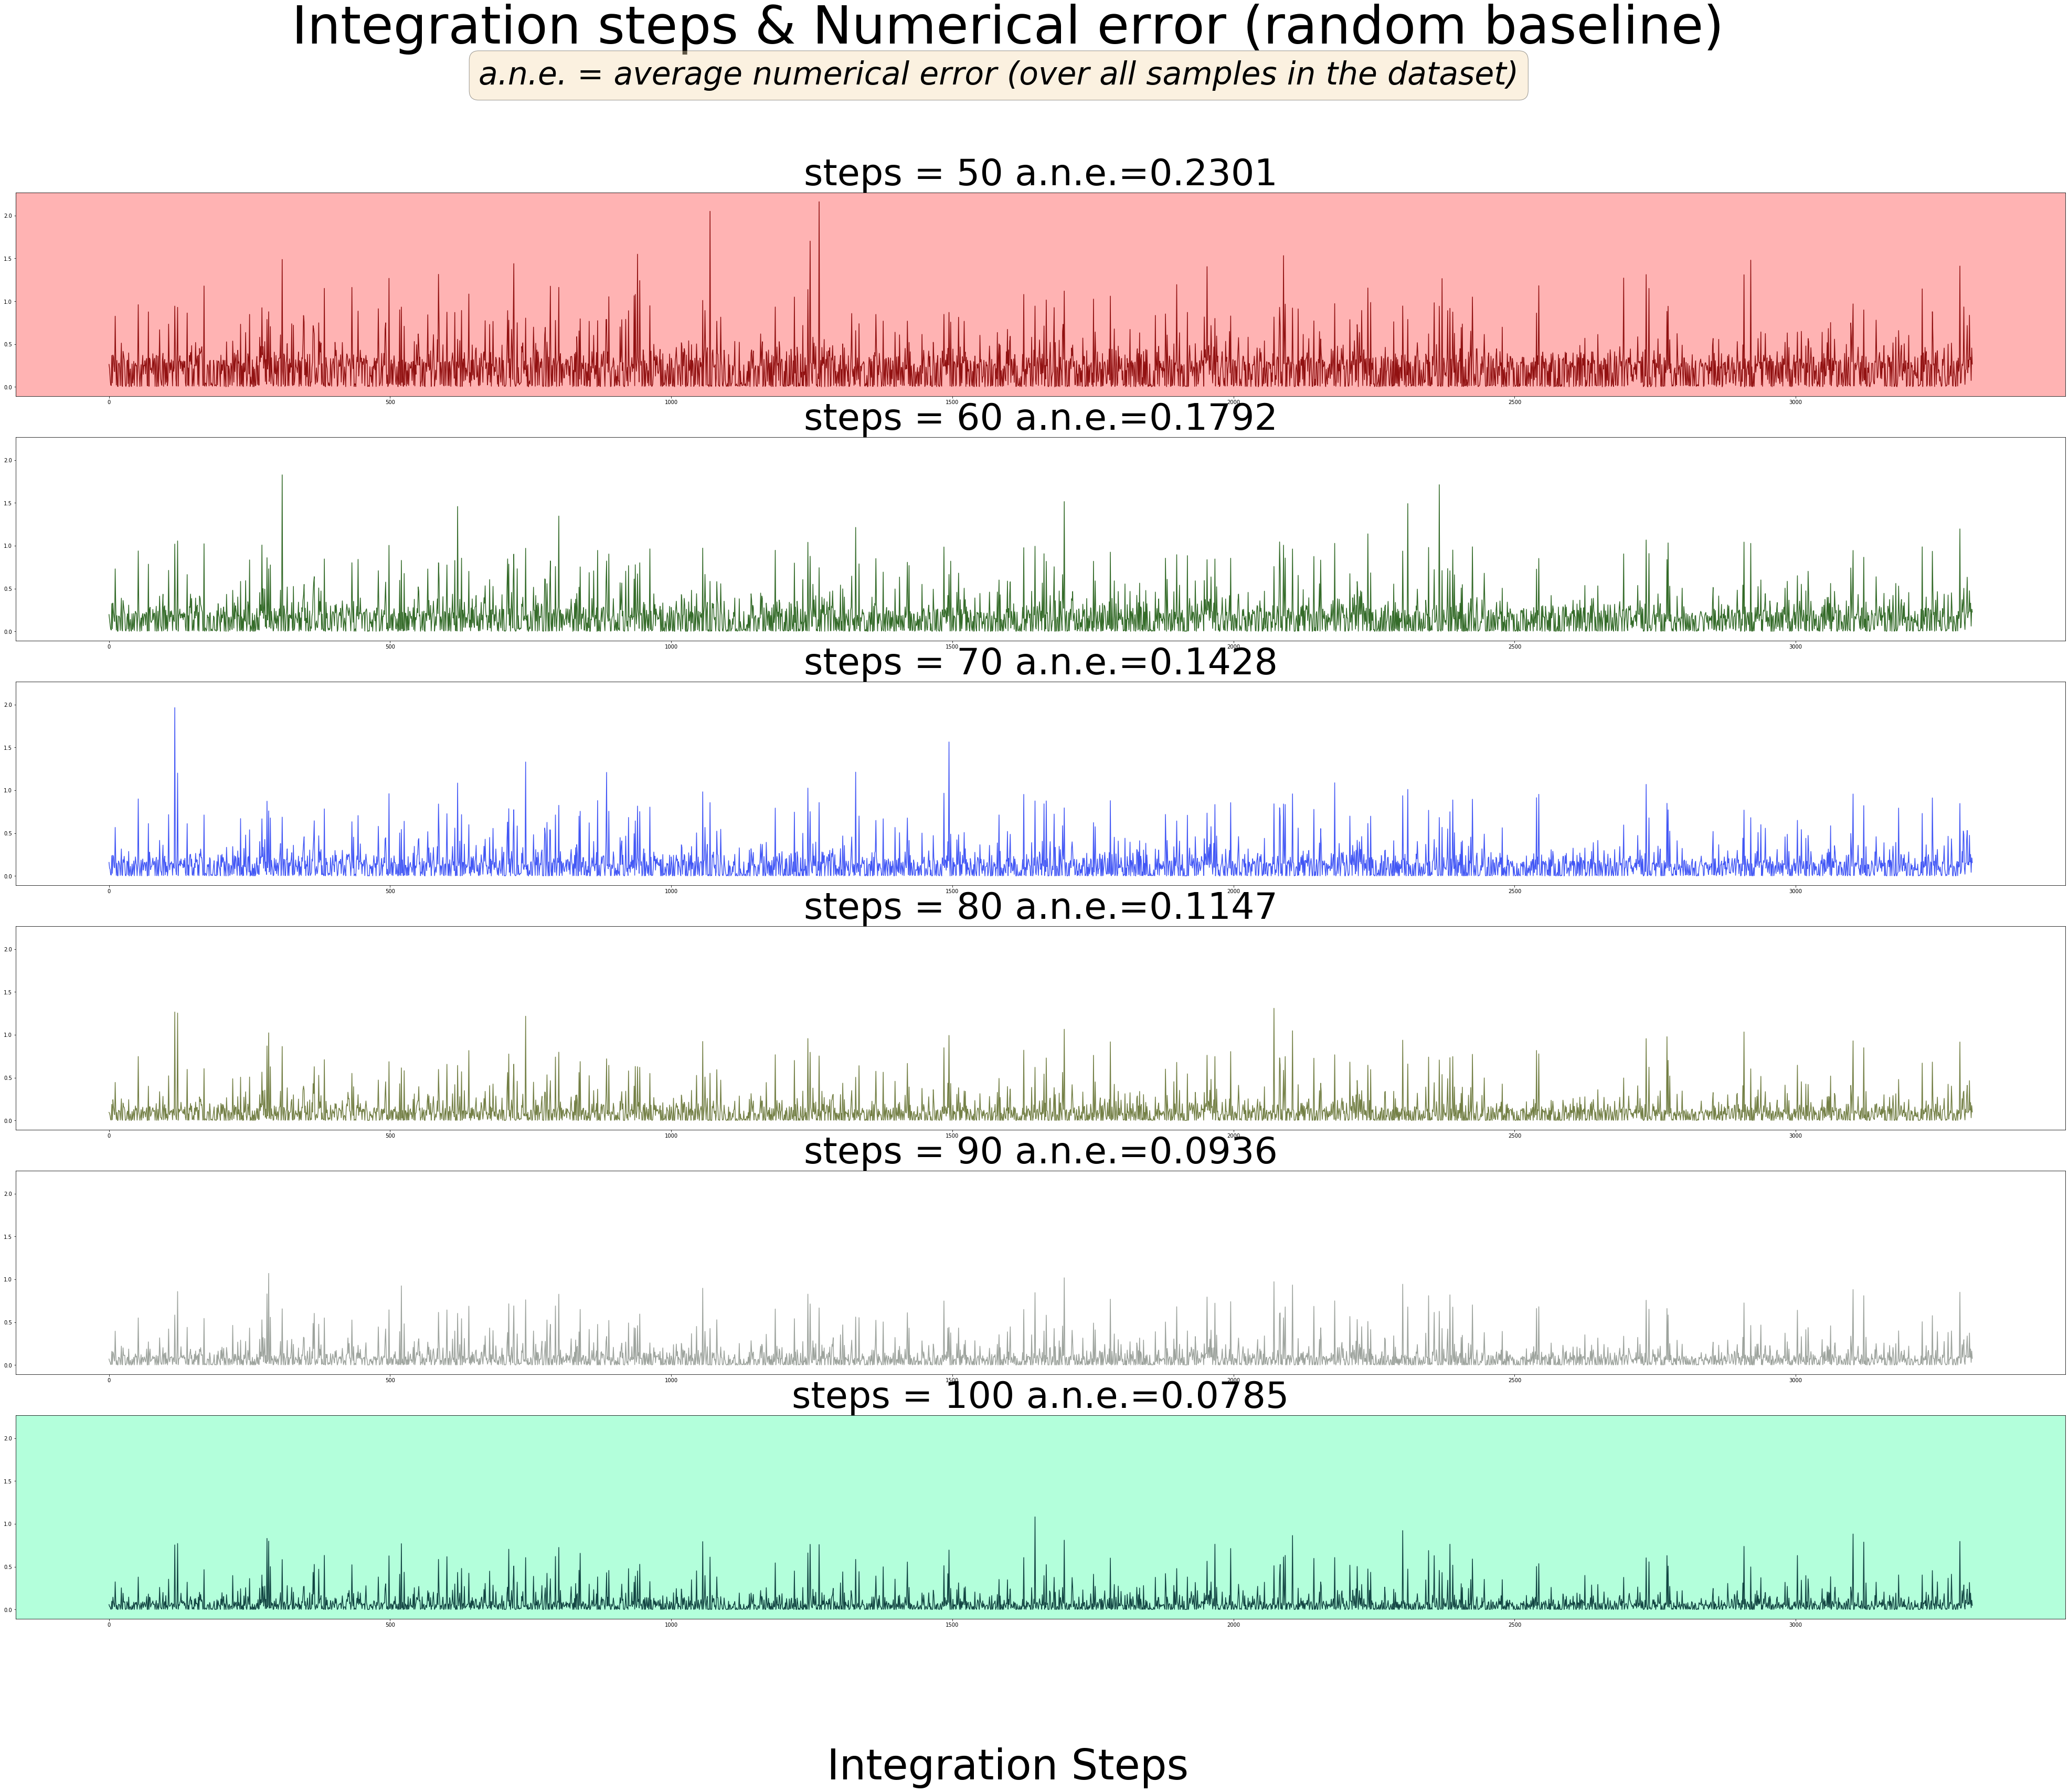

In [694]:
color_palette = ["#911111", "#346b29", "#4257f5", "#748046", "#9da39d", "#124543"]
fig, axs = plt.subplots(6, 1, figsize=(70, 50), sharey=True)
for (k, v), i in zip(numerical_errors_randoms.items(), range(len(axs))):
    axs[i].plot(v, c=color_palette[i])
    axs[i].set_title("steps = {} a.n.e.={:.4f}".format(k, numerical_errors_randoms_avg[k]), fontsize=70)
axs[0].set_facecolor(color_map['verylightred'])
axs[5].set_facecolor(color_map['verylightgreen'])
title = "Integration steps & Numerical error (random baseline)"
fig.suptitle(title, fontsize=100)
fig.text(0.5, 0.04, 'Integration Steps', ha='center', fontsize=80)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
fig.text(0.30, 0.95, 'a.n.e. = average numerical error (over all samples in the dataset)', fontsize=60, style='italic',
        verticalalignment='top', bbox=props)
fig.savefig('plots/{}'.format(title))
plt.show()

In [720]:
caption = "Average Numerical Errors (random baseline)"
pd.DataFrame.from_dict(numerical_errors_randoms_avg, orient='index', columns=['Numerical Errors']).T.style.set_caption(caption).highlight_min(axis=1, color=color_map['verylightgreen']).highlight_max(axis=1, color=color_map['verylightred'])

Now we calculate the absolute sum of the values in each vector. <u>A smaller value corresponds to the better baseline</u>.

But in order to make a statement about the numerical error we have to run the above experiment a number of times.

In [734]:
baseline_comparison = {"zero_vector": numerical_errors_avg,
                       "modal": modal_numerical_errors_avg,
                       "average": average_numerical_errors_avg,
                       "random": numerical_errors_randoms_avg}
pd.DataFrame.from_dict(baseline_comparison, orient='index').T.style.set_caption("Numerical Errors").highlight_min(axis=1, color=color_map['verylightgreen']).highlight_max(axis=1, color=color_map['verylightred']).highlight_min(axis=None, color=color_map['pleasantgreen'])

<br><br><br><br><br>

## Structural Comparison

Let's compare the molecules that the molecules in the training set to those in the test set. We are going to compare the first 8 molecule from each supplier.

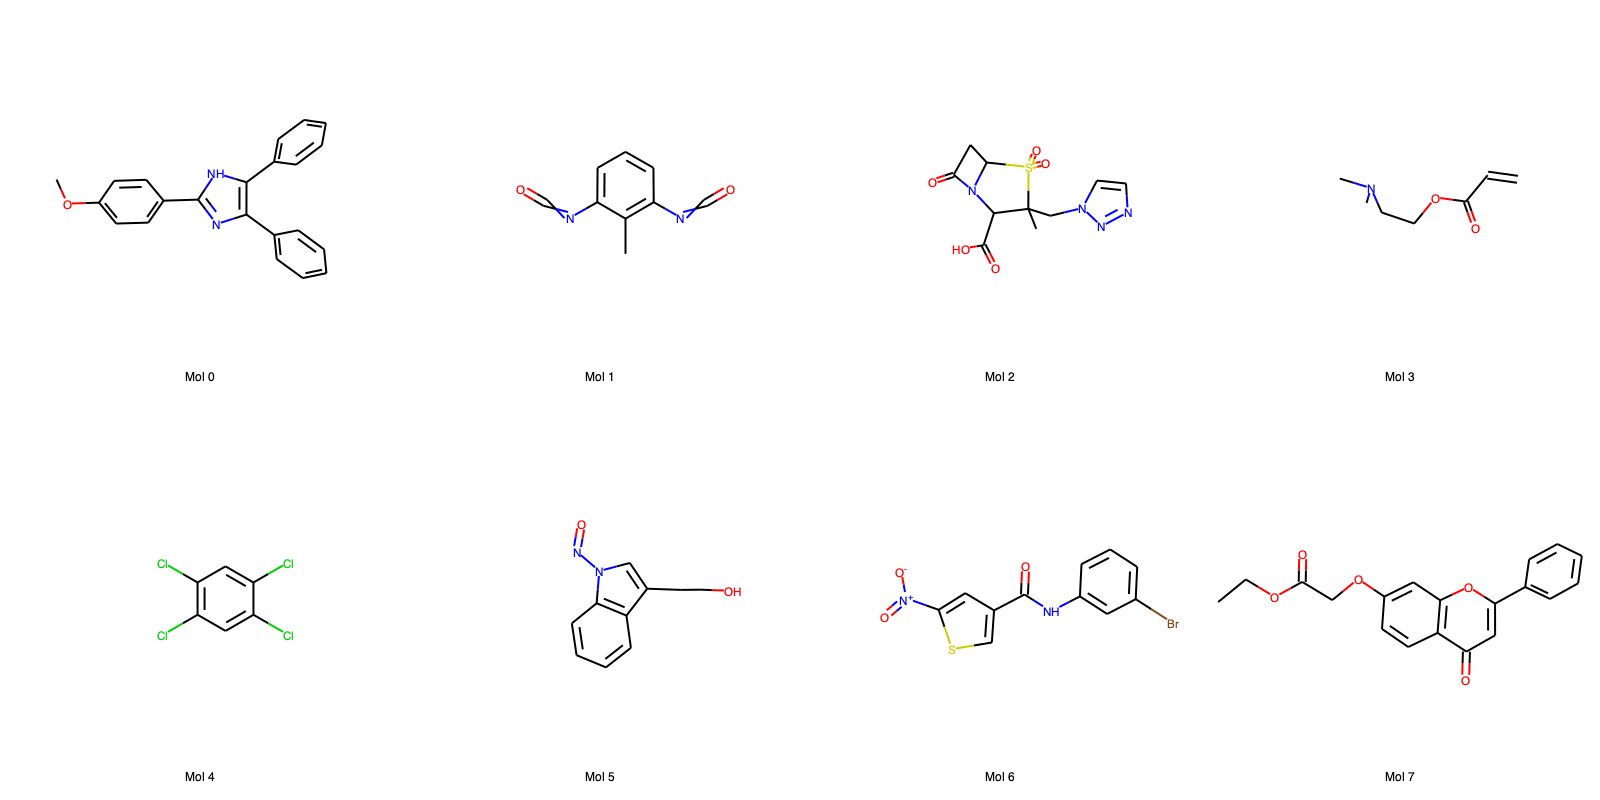

In [1143]:
supplier_1_8 = [supplier[i] for i in range(8)]
img = Draw.MolsToGridImage(supplier_1_8, molsPerRow=4, subImgSize=(400, 400), legends=["Mol {}".format(i) for i in range(len(supplier_1_8))])
img.save('plots/first_8_molecules_Train_Set.png')
img

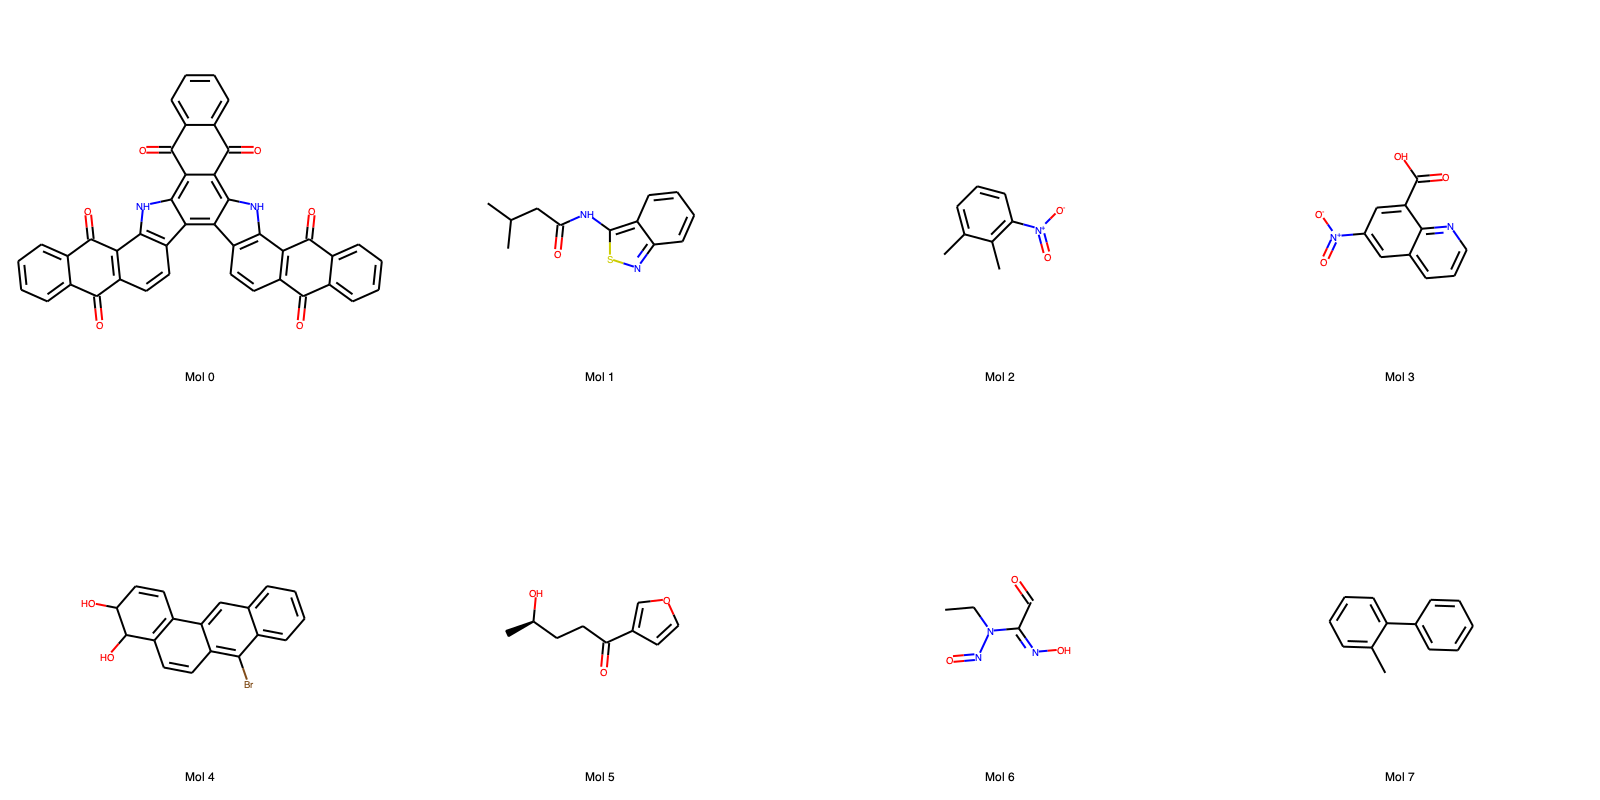

In [1144]:
img = Draw.MolsToGridImage(supplier_test[:8], molsPerRow=4, subImgSize=(400,400), legends=["Mol {}".format(i) for i in range(len(supplier_test[:8]))])
img.save('plots/first_8_molecules_Test_Set.png')
img

And these are some random 8 molecules from each set

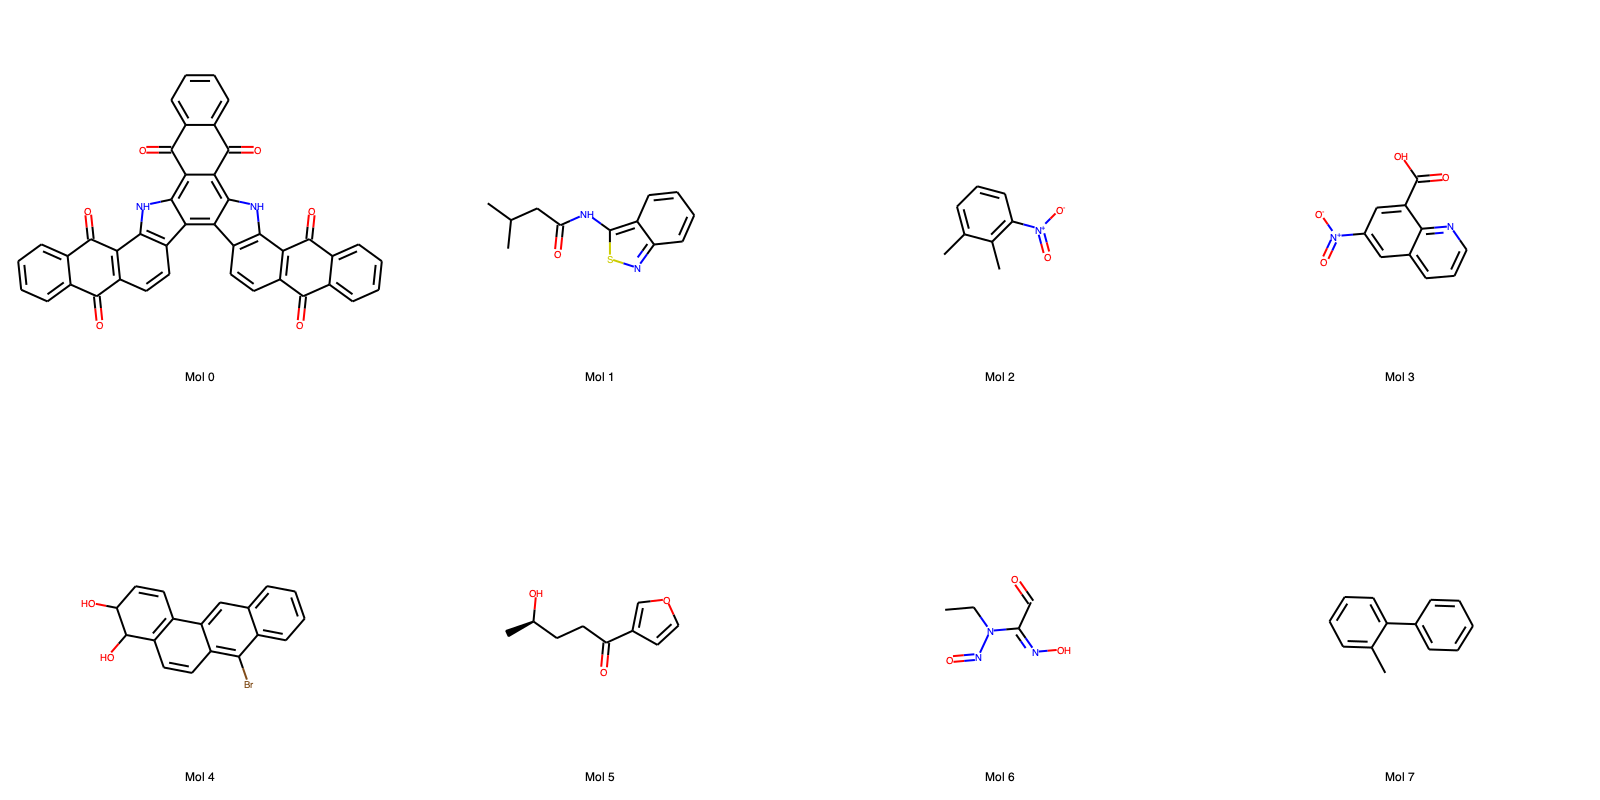

In [1145]:
randomly_generated_indices = sorted(np.random.randint(0, len(supplier), size=8))
supplier_1_8 = [supplier[int(i)] for i in randomly_generated_indices]
Draw.MolsToGridImage(supplier_1_8, molsPerRow=4, subImgSize=(400, 400), legends=["Mol {}".format(i) for i in randomly_generated_indices])
img.save('plots/randomly_selected_molecules_Train_Set.png')
img

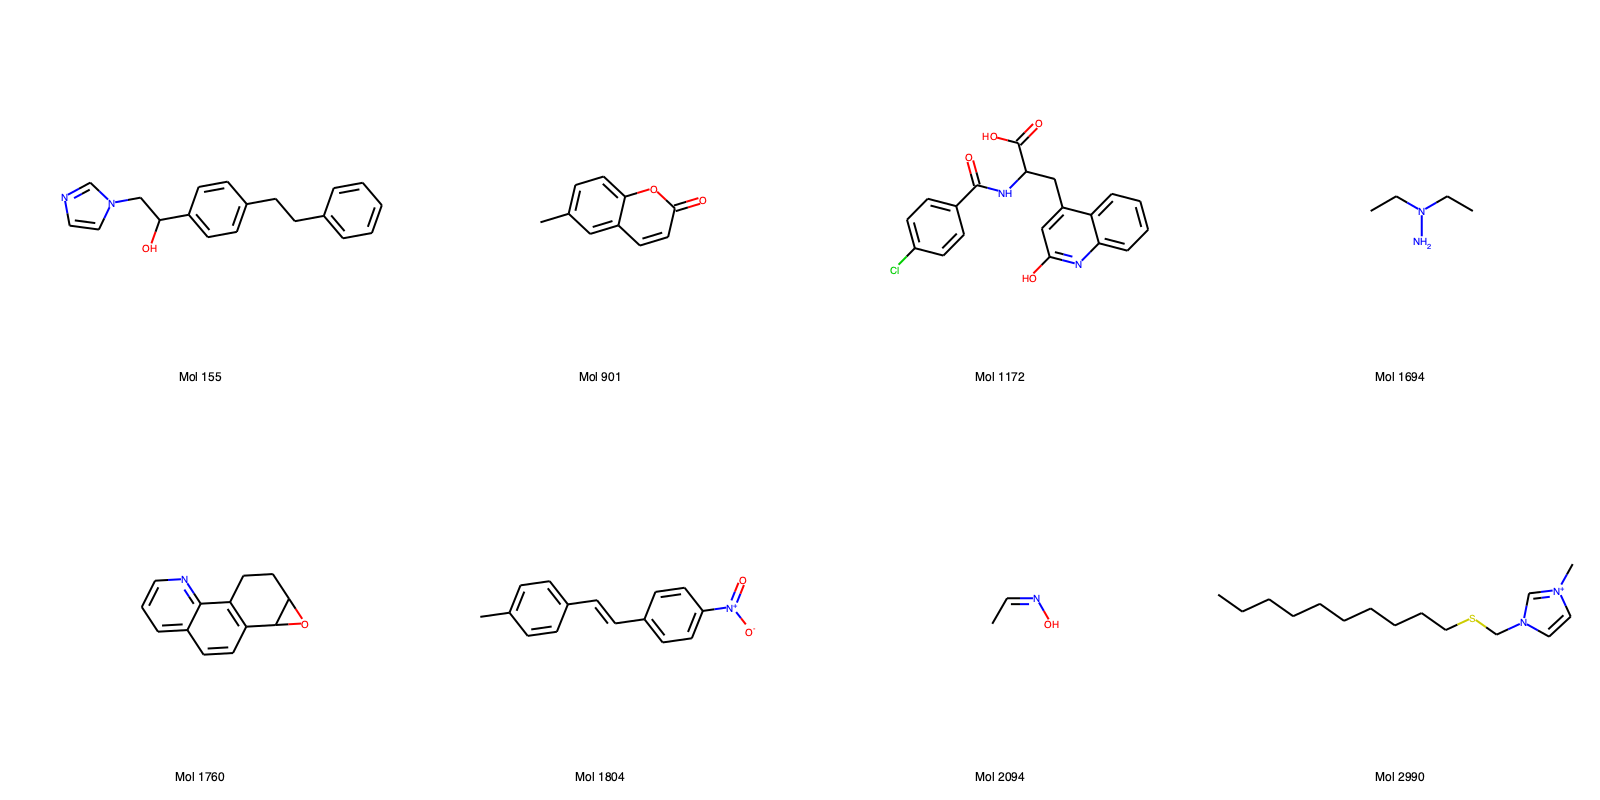

In [1146]:
randomly_generated_indices = sorted(np.random.randint(0, len(supplier_test), size=8))
supplier_1_8 = [supplier_test[int(i)] for i in randomly_generated_indices]
img = Draw.MolsToGridImage(supplier_1_8, molsPerRow=4, subImgSize=(400, 400), legends=["Mol {}".format(i) for i in randomly_generated_indices])
img.save('plots/randomly_selected_molecules_Test_Set.png')
img

## Project Attributions on Molecules

I would like to demonstrate what fingerprints (molecular structures) are signaling toxicity within a molecule. We expect these molecules to match the ones listed by the literature (Ames Test).

Also, it would be helpful to understand what a negative/positive attributions are.

Fingerprints indicated at the same index are the same, but activated by different parameters of course. Let's take the molecule $163$ and $184$ as an example and compare some of their fingerprints together.

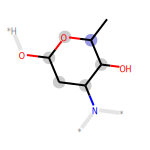

In [741]:
SVG(Draw.DrawMorganBit(supplier_test[163], 0, info_dicts[163]))

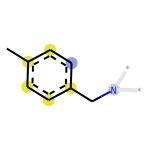

In [1147]:
SVG(Draw.DrawMorganBit(supplier_test[184], 0, info_dicts[184]))

All fingerprints found at the bit in the bit vector are "similar", <u>not identical</u>. Regardless of the fact that they've been set differently and by different parameters.

In the following I'd like to demonstrate the visualization of fingerprints attributions that we've just calculated using the integrated gradient. In order to do that, I'm going to draw one molecule and then highlight the fingerprint on top of it with both positive and negative attributions. These could be two random molecules that belong to the dataset I have.

<br><br>

----
<br>

<center><font size="5" style="font-weight: bold">Draft</font></center>

To plot the a molecule together with it specific substructure aligned in a 2-d coordinates

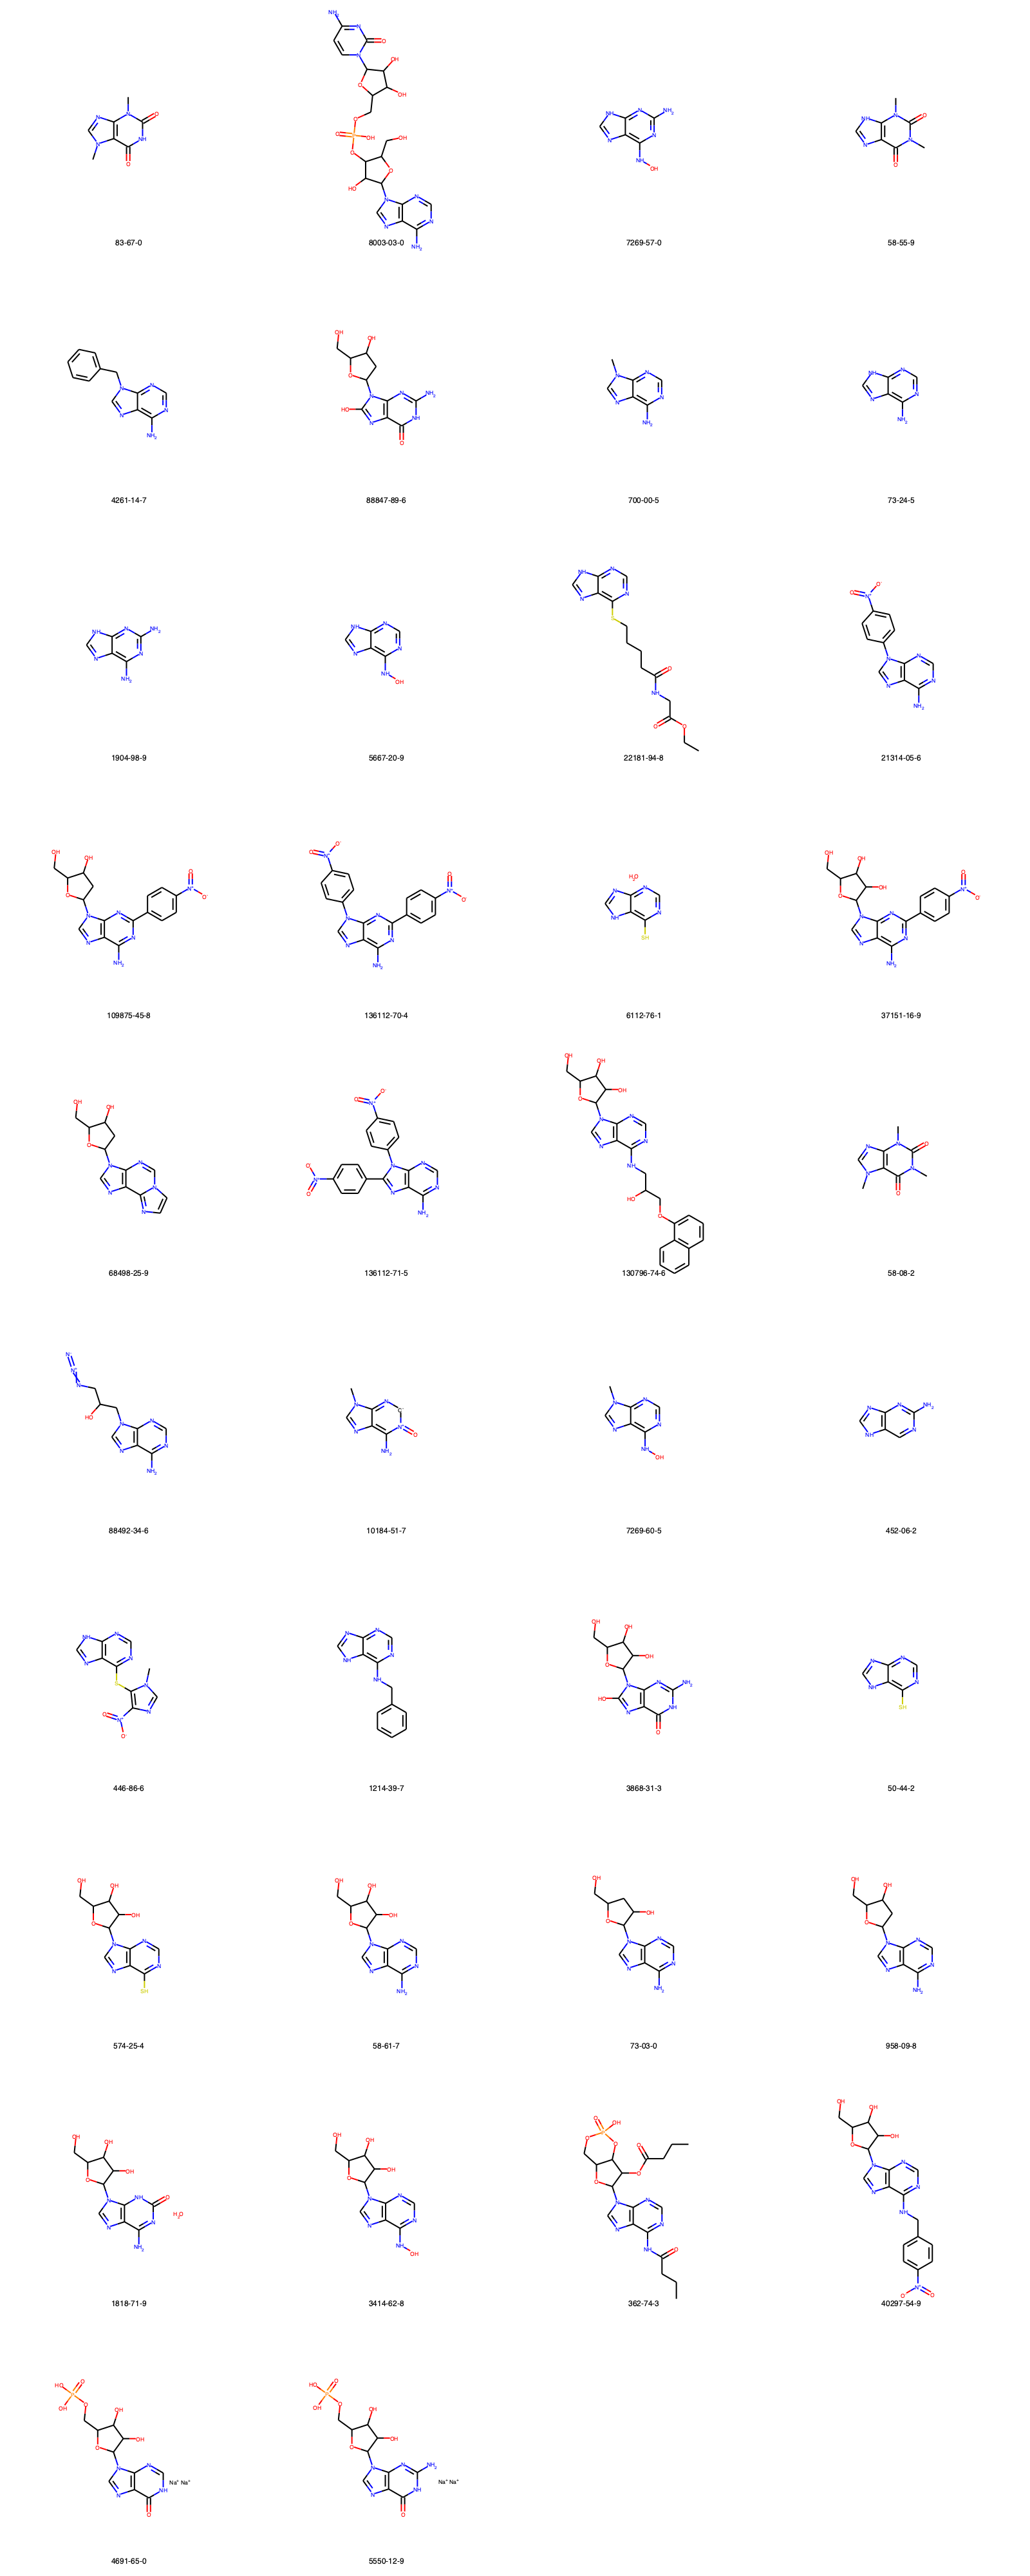

In [135]:
AllChem.Compute2DCoords(substructure)
for m in subms: AllChem.GenerateDepictionMatching2DStructure(m, substructure)
Draw.MolsToGridImage(subms,molsPerRow=4,subImgSize=(400,400),legends=[x.GetProp("_Name") for x in subms])

An alternate (and faster, particularly for large numbers of molecules) approach to do the same thing, using the function `rdkit.Chem.MolFragmentToSmiles()` :

In [ ]:
atoms=set()
for bidx in env:
    atoms.add(m.GetBondWithIdx(bidx).GetBeginAtomIdx())
    atoms.add(m.GetBondWithIdx(bidx).GetEndAtomIdx())

Chem.MolFragmentToSmiles(m,atomsToUse=list(atoms),bondsToUse=env,rootedAtAtom=5)
# 'c(C)(cc)nc'

<br><br>
<center><font size="5" style="font-weight: bold">Draft</font></center>

----

<br>

In [949]:
# 331: ((11, 3), (36, 3)),
env = Chem.FindAtomEnvironmentOfRadiusN(supplier_test[0], 3, 11)
amap={}
refmol = Chem.PathToSubmol(supplier_test[0], env, atomMap=amap)
print("num. atoms in refmol= {}, len of amap= {}".format(refmol.GetNumAtoms(), len(amap)))
print(amap)

num. atoms in refmol= 14, len of amap= 14
{0: 7, 1: 3, 2: 8, 3: 13, 7: 9, 8: 4, 9: 10, 10: 0, 11: 1, 12: 2, 13: 6, 14: 11, 15: 5, 16: 12}


In [406]:
env = Chem.FindAtomEnvironmentOfRadiusN(supplier_test[3], 3, 3)
amap= {}
fp = Chem.PathToSubmol(supplier_test[3], env, atomMap=amap)

Where can we find this environment? In fact we can find in up to $6$ places in the molecule:
1. at $0$ with radius $1$
2. at $9$ with radius $1$
3. at $20$ with radius $1$
4. at $28$ with radius $1$
5. at $38$ with radius $1$
6. at $46$ with radius $1$

Let's find out where these are...

1. **at $0$ with radius $1$**

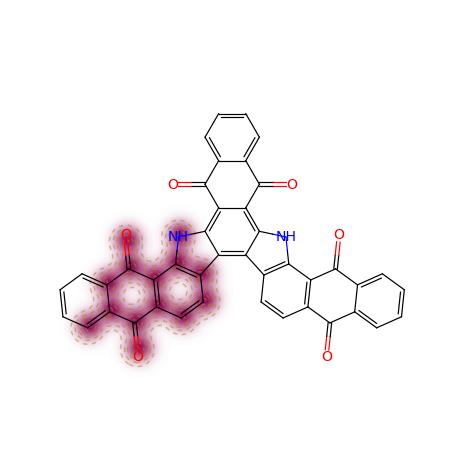

In [981]:
distrib_contrib = attributions_modal[100][0][331] / supplier_test[0].GetNumAtoms()
contribs = [distrib_contrib if i in amap.keys() else .0 for i in range(supplier_test[0].GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(supplier_test[0], contribs, contourLines=5, colors=color_map['darkorange'])

2. **at $9$ with radius $1$**

num. atoms in refmol= 14, len of amap= 14
{31: 13, 32: 8, 33: 9, 34: 4, 35: 0, 36: 1, 37: 2, 38: 5, 39: 6, 40: 10, 44: 11, 45: 7, 46: 12, 47: 3}


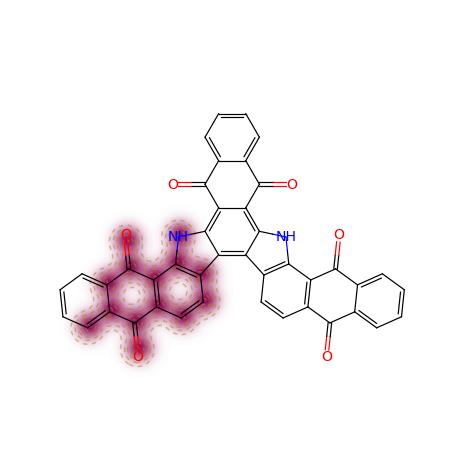

In [984]:
env = Chem.FindAtomEnvironmentOfRadiusN(supplier_test[0], 3, 36)
amap={}
refmol = Chem.PathToSubmol(supplier_test[0], env, atomMap=amap)
print("num. atoms in refmol= {}, len of amap= {}".format(refmol.GetNumAtoms(), len(amap)))
print(amap)
contribs = [distrib_contrib if i in amap.keys() else .0 for i in range(supplier_test[0].GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(supplier_test[0], contribs, contourLines=5, colors=color_map['darkorange'])

Or plot together... almost everywhere

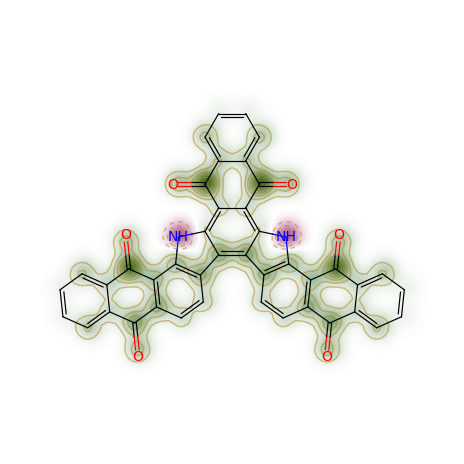

In [980]:
# Chem.Kekulize(refmol)
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, supplier_test[0], 
                           lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3), contourLines=10, colors=color_map['darkorange'], )

But most importantly, because not all atoms get the same attributions in the molecule, before assigning an attribution to an atom, we have to multiply that with the weight (importance) of the atom.

In [1012]:
weights = SimilarityMaps.GetAtomicWeightsForFingerprint(refmol, supplier_test[0],
                                lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3))
contribs = [distrib_contrib * weights[i] if i in amap.keys() else .0 for i in range(supplier_test[0].GetNumAtoms())]

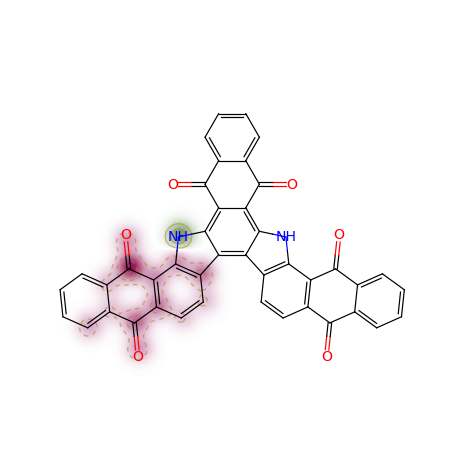

In [1020]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(supplier_test[0], contribs, contourLines=8, colors=color_map['darkorange'])

And when the fingerprint drawn separately...

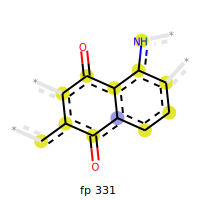

In [1030]:
SVG(Draw.DrawMorganEnv(supplier_test[0], 36, 3, molSize=(200, 200), legend="fp 331"))

In [1242]:
most_frequent_fp_id = X_test.sum(axis=0).argmax() # 1380
print(most_frequent_fp_id)
molecules_with_fp1380 = X_test[X_test.T[most_frequent_fp_id] == 1]
molecules_ids_with_fp1380 = np.where(X_test.T[most_frequent_fp_id] == 1)[0]

refmols = contribs = np.empty(shape=X_test.shape)
amaps = np.array([{} for x in range(X_test.size)]).reshape(X_test.shape)

1380


In [ ]:
%%pixie_debugger
for id, i in zip(molecules_ids_with_fp1380, range(5)):
    id = int(id)
    # reconstruct the environment
    env = Chem.FindAtomEnvironmentOfRadiusN(supplier_test[id], info_dicts[id][1380][0][1], info_dicts[id][1380][0][0])
    amap = {}
    refmols[id, 1380] = Chem.PathToSubmol(supplier_test[id], env, atomMap=amap)
    amaps[id, 1380] = amap
    # calculate the atomic weights & contributions
    weights = SimilarityMaps.GetAtomicWeightsForFingerprint(refmols[id, 1380], supplier_test[id],
                                lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3))
    distrib_contrib = attributions_modal[100][id][1380] / refmols[id, 1380].GetNumAtoms()
    contribs[id, 1380] = [distrib_contrib * weights[i] if i in amaps[id, 1380].keys() else .0 for i in range(supplier_test[id].GetNumAtoms())]
    # plot similarity from weights
    fig = SimilarityMaps.GetSimilarityMapFromWeights(supplier_test[id], contribs[id, 1380], contourLines=8, colors=color_map['darkorange'])

## Example of OE

In [ ]:
from openeye import oechem
mol = oechem.OEGraphMol()

In [3]:
oechem.OESmilesToMol(mol, "c1cncc2c1cc3c(cncc3)c2")

NameError: name 'mol' is not defined

In [ ]:

oechem.OESmilesToMol(mol, "c1cncc2c1cc3c(cncc3)c2")
oedepict.OEPrepareDepiction(mol)

subs = oechem.OESubSearch("c1cc[c,n]cc1")

opts = oedepict.OE2DMolDisplayOptions(240.0, 100.0, oedepict.OEScale_AutoScale)
opts.SetMargins(10.0)
disp = oedepict.OE2DMolDisplay(mol, opts)

highlight = oedepict.OEHighlightOverlayByBallAndStick(oechem.OEGetContrastColors())

unique = True
oedepict.OEAddHighlightOverlay(disp, highlight, subs.Match(mol, unique))

oedepict.OERenderMolecule("HighlightOverlay.png", disp)